<a href="https://colab.research.google.com/github/adilrahman/complaint-classification-app/blob/main/model_building/model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip AIQ1.zip

Archive:  AIQ1.zip
   creating: AIQ1/
  inflating: AIQ1/AIQ1.docx          
  inflating: AIQ1/aml_eval.csv       
  inflating: AIQ1/aml_train.csv      
  inflating: AIQ1/complaints-2021-09-08_07_12.csv  


In [ ]:
%%capture
!pip install contractions
!pip install -U kaleido

## Importing packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # for visualize the null values in datase
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle

## models
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## text preprocessing
import nltk
import re
from nltk import word_tokenize, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
import contractions # removing contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%capture
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Analysis of datasets

In [ ]:
df = pd.read_csv("/content/AIQ1/complaints-2021-09-08_07_12.csv")

In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/27/21,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was result of identity theft,NaN,None,Bonneville Billing and Collections,FL,33256,None,None,Web,08/27/21,Closed with explanation,Yes,NaN,4669189
1,08/08/21,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,None,BOEING EMPLOYEES CREDIT UNION,WA,None,None,None,Web,08/08/21,Closed with explanation,Yes,NaN,4612302
2,08/14/21,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,None,"Frontline Asset Strategies, LLC",GA,300XX,None,None,Web,08/14/21,Closed with explanation,Yes,NaN,4632146
3,08/27/21,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,None,"Credence Resource Management, LLC",OH,43213,None,None,Web,08/27/21,In progress,Yes,NaN,4668465
4,08/25/21,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,NaN,Company has responded to the consumer and the ...,"I.C. System, Inc.",FL,32839,None,Consent not provided,Web,08/25/21,Closed with explanation,Yes,NaN,4658212


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49826 entries, 0 to 49825
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 49826 non-null  object 
 1   Product                       49826 non-null  object 
 2   Sub-product                   49826 non-null  object 
 3   Issue                         49826 non-null  object 
 4   Sub-issue                     49826 non-null  object 
 5   Consumer complaint narrative  5132 non-null   object 
 6   Company public response       49826 non-null  object 
 7   Company                       49826 non-null  object 
 8   State                         49826 non-null  object 
 9   ZIP code                      49826 non-null  object 
 10  Tags                          49826 non-null  object 
 11  Consumer consent provided?    46900 non-null  object 
 12  Submitted via                 49826 non-null  object 
 13  D

In [ ]:
def null_values_percentage(df):
  '''
  description:
    This function help to find the percentage of unique values exist in 
    each feature/columns
  '''
  total_count = df.shape[0]
  print(f"-------------------> {total_count} [records] <-------------\n")
  for col in df.columns:
    null_count = df[col].isnull().sum()

    #print only null values details 
    if null_count == 0.0: continue 

    print(f"{null_count/total_count*100:0.3f}% \t:\t {col}")

  #visualize the missing values
  print()
  plt.figure(figsize=(1,5)) 
  msno.bar(df)

-------------------> 49826 [records] <-------------

89.700% 	:	 Consumer complaint narrative
5.872% 	:	 Consumer consent provided?
100.000% 	:	 Consumer disputed?



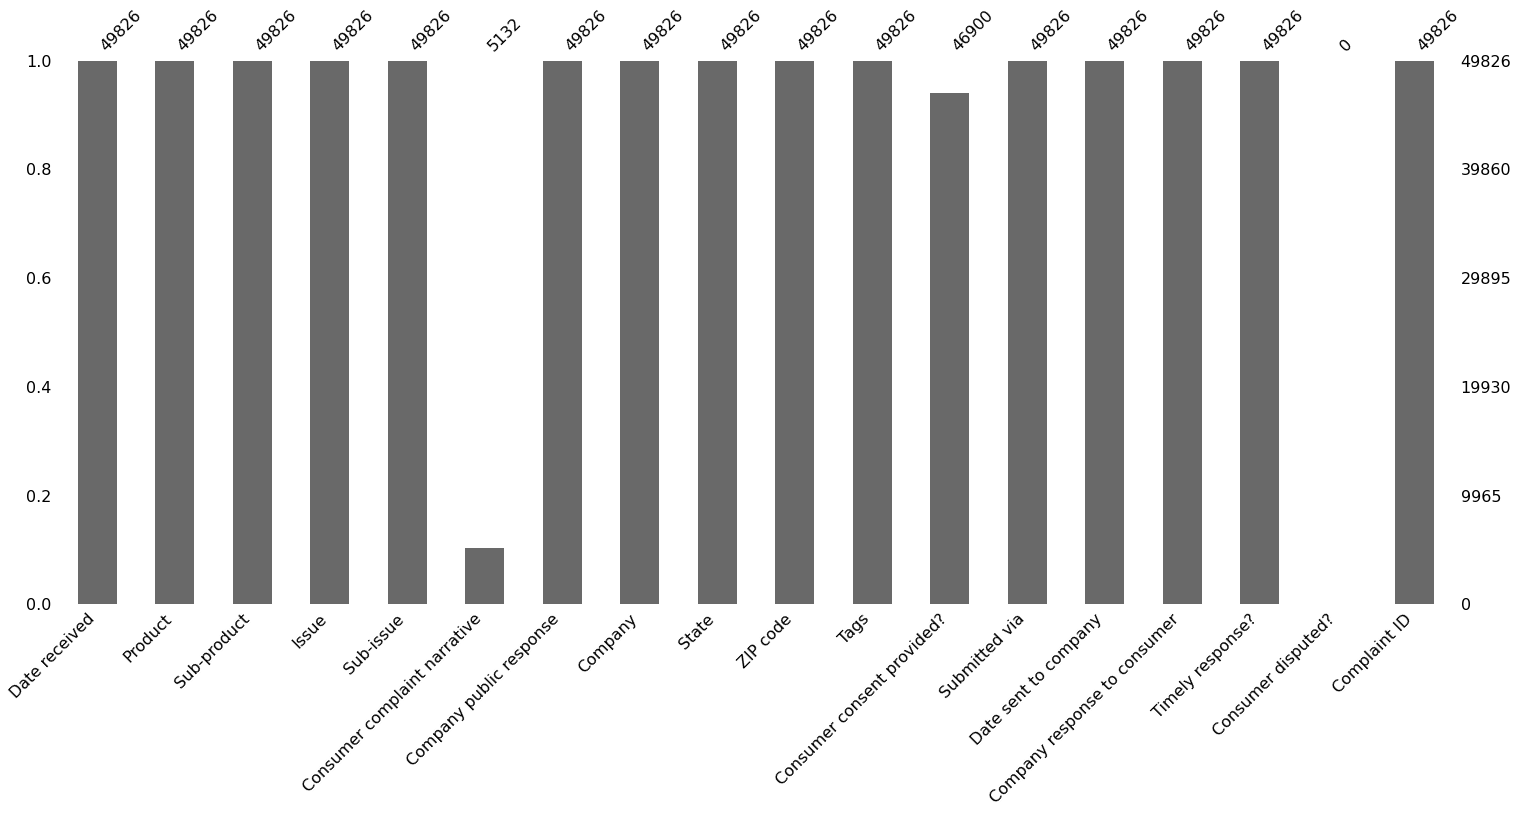

In [ ]:
null_values_percentage(df)

In [ ]:
## selecting the required columns
df = df[["Consumer complaint narrative","Product", "Sub-product" ,"Issue", "Sub-issue"]]
df

,Consumer complaint narrative,Product,Sub-product,Issue,Sub-issue
0,NaN,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was result of identity theft
1,NaN,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect
2,NaN,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else
3,NaN,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days
4,NaN,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid
...,...,...,...,...,...
49821,NaN,Credit card or prepaid card,Gift card,Unexpected or other fees,None
49822,NaN,Debt collection,I do not know,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...
49823,NaN,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days
49824,NaN,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft


In [ ]:
## droping all null records/rows
df.dropna(inplace = True)
df = df.reset_index()
df

,index,Consumer complaint narrative,Product,Sub-product,Issue,Sub-issue
0,41,Experian has allowed 6 inquiries on my credit ...,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else
1,44,I submitted documentation from XXXX that I sub...,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Difficulty submitting a dispute or getting inf...
2,121,I contacted XXXX XXXX to inquire as to why a t...,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else
3,122,IC Systems Re : Dispute of Account No. XXXX XX...,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours
4,153,This is the 3 time I have disputed and filed a...,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect
...,...,...,...,...,...,...
5127,49773,I get an alert from XXXX XXXX there a collecti...,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect
5128,49776,XX/XX/XXXX received letter from State of Calif...,Mortgage,FHA mortgage,Trouble during payment process,None
5129,49796,RE : Attentively review my formal writ compose...,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was result of identity theft
5130,49801,I have tried to call Experian several times an...,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect


**Words cloud before cleaning text**

---



In [ ]:
_stopwords = set(STOPWORDS)

In [ ]:
def produce_wordcloud(df,col):
  '''
  description:
    it generate a word cloud using the values of given col
  '''
  plt.figure(figsize=(20,10))
  string = ""
  for content in df[col]:
      content = content.lower()
      string += " " + content + " "
  wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,stopwords = _stopwords,width=2200, height=2200).generate(string)
  plt.imshow(wordcloud)
  plt.title(f"Words Cloud of {col}")
  plt.axis("off")
  

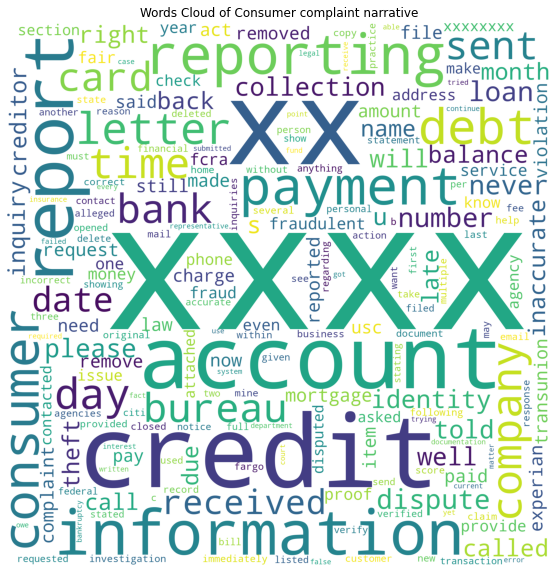

In [ ]:
col = "Consumer complaint narrative"
produce_wordcloud(df,col)

In [ ]:
## checking different patterns in the text for cleaning purpose
df["Consumer complaint narrative"].loc[1513]

"I called to XXXX XXXX XXXX XXXX and they are not seeing any lates on my account. Somehow, the are showing that I had an {$8.00} balance that is reporting 30 days late for XX/XX/2021. I was never late. I am on auto pay. This should never have hit my credit and XXXX XXXXXXXX doesn't show me anything was late. I spoke to XXXX and they are confused by all of this. This dropped my credit 40 points and I am trying to purchase a home!"

**Observed** :

- money format -> {$8000}
- remove '\n'
- remove contraction eg: 'wasn't' , can't
- mark numerical numbers as 'number' in string 
- date format 'xx/xx/21' -> 'data'




## Text preprocessing

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
def stem(word):
    return stemmer.stem(word.lower())

In [ ]:
def tokenizer(sentance):
    return word_tokenize(sentance)

In [ ]:
import re

def text_cleaning(text : str) -> str:
  '''
  description:
    it clean the text
      - change to lower case
      - remove the numerical numbers
      - remove newline symbols , special symbols, whitespace
      - transforming every tokens into it's stem form
      - expanding the contractions
  '''
  text = text.lower()
  
  # change numerical money format to 'money' 
  text = re.sub("\$[0-9.]+","dollar money",text)
  # removing the newline symbols '\n'
  text = re.sub("\n"," ",text)

  #changing format of dates
  text = re.sub("[0-9x]+/[0-9x]+/[0-9x]+"," date ",text)

  text = re.sub(r"[0-9]+","number",text)
  text = re.sub(r"xx+", "", text)
  text = re.sub(r"[^a-zA-Z ]+"," ",text)
  text = re.sub(r"\s+"," ",text)
  text = text.lstrip().rstrip()
  tokens = tokenizer(sentance=text)
  #
  tokens = [stemmer.stem(contractions.fix(token)) for token in tokens if token not in stop_words ]
  text = " ".join(tokens).lstrip().rstrip()

  return text



In [ ]:
df["Consumer complaint narrative"] = df["Consumer complaint narrative"].apply(text_cleaning)

In [ ]:
df["Consumer complaint narrative"].loc[1513]

'call see late account somehow show dollar money balanc report number day late date never late auto pay never hit credit show anyth late spoke confus drop credit number point tri purchas home'

**Word Cloud after cleaning**

---



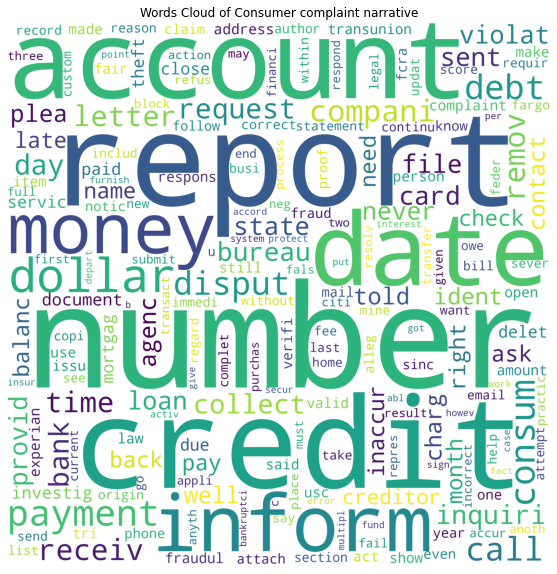

In [ ]:
col = "Consumer complaint narrative"
tmp_df = df.copy()
tmp_df = pd.DataFrame(tmp_df).reset_index()
produce_wordcloud(tmp_df,col)

## **Function for finding less frequent column values**
----

In [ ]:
def find_less_frequent_values(df, col_name, threashold = 100):
  '''
  description:
    it find the column/class value that having value count less than threshold  
  '''
  x = []
  for value in df[col_name].unique():
    num = df[df[col_name] == value].shape[0]
    if num < threashold:
      x.append(value)
    
  return x

In [ ]:
def change_class(cls):
  if cls in other_values:
    return "other"
  else:
    return cls

## **Checking the product column values distribution and removing less frequent values**


---



In [ ]:
df_product = df[["Consumer complaint narrative", "Product"]]

In [ ]:
df_product["Product"].unique() , df_product["Product"].nunique() 

(array(['Credit reporting, credit repair services, or other personal consumer reports',
        'Debt collection', 'Checking or savings account', 'Mortgage',
        'Credit card or prepaid card',
        'Money transfer, virtual currency, or money service',
        'Vehicle loan or lease',
        'Payday loan, title loan, or personal loan', 'Student loan'],
       dtype=object), 9)

In [ ]:
values_count = df_product["Product"].value_counts() 
values_count

Credit reporting, credit repair services, or other personal consumer reports    3151
Debt collection                                                                  790
Credit card or prepaid card                                                      343
Mortgage                                                                         337
Checking or savings account                                                      292
Vehicle loan or lease                                                            107
Money transfer, virtual currency, or money service                                59
Payday loan, title loan, or personal loan                                         42
Student loan                                                                      11
Name: Product, dtype: int64

In [ ]:
## finding column/class values that are less frequent
other_values = find_less_frequent_values(df_product, col_name = "Product")
len(other_values)

3

In [ ]:
num = df_product["Product"].nunique() - len(other_values)
print(f"number of classes after processing : {num}")

number of classes after processing : 6


In [ ]:
df_product["Product"] = df_product["Product"].apply(change_class)
df_product = df_product[df_product["Product"] != "other"]
df_product

,Consumer complaint narrative,Product
0,experian allow number inquiri credit report di...,"Credit reporting, credit repair services, or o..."
1,submit document submit includ origin disput to...,"Credit reporting, credit repair services, or o..."
2,contact inquir transact take long agent verifi...,"Credit reporting, credit repair services, or o..."
3,ic system disput account may concern write inf...,Debt collection
4,number time disput file complaint cfpb ftc ove...,"Credit reporting, credit repair services, or o..."
...,...,...
5127,get alert collect credit report never contact ...,"Credit reporting, credit repair services, or o..."
5128,date receiv letter state california chief depu...,Mortgage
5129,attent review formal writ compos declar proven...,Debt collection
5130,tri call experian sever time answer get voic m...,"Credit reporting, credit repair services, or o..."


## **Checking the different sub-product column values distribution removing less frequent values**


---



In [ ]:
df_sub_product = df[["Consumer complaint narrative", "Sub-product"]]

In [ ]:
df_sub_product["Sub-product"].unique() , df_sub_product["Sub-product"].nunique() 

(array(['Credit reporting', 'Other debt', 'Credit card debt',
        'I do not know', 'Savings account',
        'Home equity loan or line of credit (HELOC)', 'Store credit card',
        'Conventional home mortgage',
        'General-purpose credit card or charge card',
        'Mobile or digital wallet', 'Checking account', 'FHA mortgage',
        'Domestic (US) money transfer', 'Other personal consumer report',
        'Loan', 'VA mortgage', 'Auto debt', 'Lease', 'Medical debt',
        'Other banking product or service', 'Mortgage debt',
        'Other type of mortgage', 'Federal student loan debt',
        'Payday loan debt', 'Installment loan', 'Check cashing service',
        'International money transfer', 'Private student loan',
        'Personal line of credit', 'Government benefit card',
        'General-purpose prepaid card', 'Private student loan debt',
        'Federal student loan servicing', 'Refund anticipation check',
        "Traveler's check or cashier's check", 'T

In [ ]:
df_sub_product["Sub-product"].value_counts()

Credit reporting                              3119
General-purpose credit card or charge card     266
Other debt                                     245
Checking account                               233
Conventional home mortgage                     213
Credit card debt                               208
I do not know                                  137
Medical debt                                   130
Loan                                            89
FHA mortgage                                    63
Store credit card                               54
Auto debt                                       45
Savings account                                 32
Other personal consumer report                  29
VA mortgage                                     29
Domestic (US) money transfer                    27
Other banking product or service                25
Personal line of credit                         20
Lease                                           18
Other type of mortgage         

In [ ]:
## finding column/class values that are less frequent
other_values = find_less_frequent_values(df_sub_product ,col_name = "Sub-product")
len(other_values)

34

In [ ]:
num = df_sub_product["Sub-product"].nunique() - len(other_values)
print(f"number of classes after processing : {num}")

number of classes after processing : 8


In [ ]:
df_sub_product["Sub-product"] = df_sub_product["Sub-product"].apply(change_class)
df_sub_product = df_sub_product[df_sub_product["Sub-product"] != "other"]
df_sub_product

,Consumer complaint narrative,Sub-product
0,experian allow number inquiri credit report di...,Credit reporting
1,submit document submit includ origin disput to...,Credit reporting
2,contact inquir transact take long agent verifi...,Credit reporting
3,ic system disput account may concern write inf...,Other debt
4,number time disput file complaint cfpb ftc ove...,Credit reporting
...,...,...
5126,transunion profil special depart explain idea ...,Credit reporting
5127,get alert collect credit report never contact ...,Credit reporting
5129,attent review formal writ compos declar proven...,Credit card debt
5130,tri call experian sever time answer get voic m...,Credit reporting


## **Checking the different issues column values distribution removing less frequent values**


---



In [ ]:
df_issue = df[["Consumer complaint narrative", "Issue"]]

In [ ]:
df_issue["Issue"].unique() , df_issue["Issue"].nunique() 

(array(['Incorrect information on your report',
        "Problem with a credit reporting company's investigation into an existing problem",
        'Attempts to collect debt not owed',
        'False statements or representation', 'Closing an account',
        'Communication tactics', 'Closing on a mortgage',
        'Fees or interest',
        'Applying for a mortgage or refinancing an existing mortgage',
        'Took or threatened to take negative or legal action',
        'Other features, terms, or problems',
        'Trouble during payment process',
        'Unauthorized transactions or other transaction problem',
        'Problem with fraud alerts or security freezes',
        'Managing an account',
        'Problem with a purchase shown on your statement',
        'Advertising and marketing, including promotional offers',
        'Closing your account',
        'Threatened to contact someone or share information improperly',
        'Improper use of your report', 'Fraud or scam'

In [ ]:
df_issue["Issue"].value_counts()

Incorrect information on your report                                                1654
Problem with a credit reporting company's investigation into an existing problem    1064
Attempts to collect debt not owed                                                    439
Improper use of your report                                                          380
Managing an account                                                                  157
                                                                                    ... 
Vehicle was damaged or destroyed the vehicle                                           1
Identity theft protection or other monitoring services                                 1
Other service problem                                                                  1
Problem with cash advance                                                              1
Wrong amount charged or received                                                       1
Name: Issue, Length: 

In [ ]:
## finding column/class values that are less frequent
other_values = find_less_frequent_values(df_issue, col_name = "Issue")
len(other_values)

58

In [ ]:
num = df_issue["Issue"].nunique() - len(other_values)
print(f"number of classes after processing : {num}")

number of classes after processing : 7


In [ ]:
df_issue["Issue"] = df_issue["Issue"].apply(change_class)
df_issue = df_issue[df_issue["Issue"] != "other"]
df_issue

,Consumer complaint narrative,Issue
0,experian allow number inquiri credit report di...,Incorrect information on your report
1,submit document submit includ origin disput to...,Problem with a credit reporting company's inve...
2,contact inquir transact take long agent verifi...,Incorrect information on your report
3,ic system disput account may concern write inf...,Attempts to collect debt not owed
4,number time disput file complaint cfpb ftc ove...,Incorrect information on your report
...,...,...
5127,get alert collect credit report never contact ...,Incorrect information on your report
5128,date receiv letter state california chief depu...,Trouble during payment process
5129,attent review formal writ compos declar proven...,Attempts to collect debt not owed
5130,tri call experian sever time answer get voic m...,Incorrect information on your report


##**Checking the different sub-issues column values distribution removing less frequent values**


---

In [ ]:
df_sub_issue = df[["Consumer complaint narrative", "Sub-issue"]]

In [ ]:
df_sub_issue["Sub-issue"].unique() , df_sub_issue["Sub-issue"].nunique() 

(array(['Information belongs to someone else',
        'Difficulty submitting a dispute or getting information about a dispute over the phone',
        'Debt is not yours', 'Personal information incorrect',
        'Their investigation did not fix an error on your report',
        'Attempted to collect wrong amount',
        'Funds not received from closed account',
        'Investigation took more than 30 days',
        'Used obscene, profane, or other abusive language',
        'Account status incorrect', 'None', 'Charged too much interest',
        'Threatened to sue you for very old debt',
        'Public record information inaccurate',
        'Was not notified of investigation status or results',
        'Debt was result of identity theft', 'Other problem',
        'Deposits and withdrawals', 'Account information incorrect',
        "Credit card company isn't resolving a dispute about a purchase on your statement",
        "Didn't receive advertised or promotional terms",
       

In [ ]:
df_sub_issue["Sub-issue"].value_counts()

Information belongs to someone else                              813
Their investigation did not fix an error on your report          582
None                                                             466
Account information incorrect                                    299
Account status incorrect                                         291
                                                                ... 
Can't temporarily delay making payments                            1
Don't want a card provided by your employer or the government      1
Problem while selling or giving up the vehicle                     1
Keep getting calls about your loan                                 1
Contacted your employer                                            1
Name: Sub-issue, Length: 127, dtype: int64

In [ ]:
## finding column/class values that are less frequent
other_values = find_less_frequent_values(df_sub_issue, col_name = "Sub-issue")
len(other_values)

116

In [ ]:
num = df_sub_issue["Sub-issue"].nunique() - len(other_values)
print(f"number of classes after processing : {num}")

number of classes after processing : 11


In [ ]:
df_sub_issue["Sub-issue"] = df_sub_issue["Sub-issue"].apply(change_class)
df_sub_issue = df_sub_issue[df_sub_issue["Sub-issue"] != "other"]
df_sub_issue

,Consumer complaint narrative,Sub-issue
0,experian allow number inquiri credit report di...,Information belongs to someone else
2,contact inquir transact take long agent verifi...,Information belongs to someone else
3,ic system disput account may concern write inf...,Debt is not yours
5,account incorect balanc inform pleas updat acc...,Their investigation did not fix an error on yo...
7,two medic bill show credit dollar money dollar...,Information belongs to someone else
...,...,...
5122,believ victim ident theft due pandem face lot ...,Debt was result of identity theft
5123,date check credit websit notic fraudul account...,Information belongs to someone else
5128,date receiv letter state california chief depu...,None
5129,attent review formal writ compos declar proven...,Debt was result of identity theft



## Model evaluation functions



In [ ]:
def base_model_evaluation(X_train,y_train,X_test,y_test, y_label_names = None ,model =  MultinomialNB()):
  '''
  description: 
    it fit the training dataset on the given base model 
    and evaluate on train and test and generate classification report 
  '''
  base_model = model
  base_model.fit(X_train, y_train)
  train_pred = base_model.predict(X_train) 
  test_pred = base_model.predict(X_test)
  train_report = classification_report(y_train, train_pred, target_names=y_label_names)
  test_report = classification_report(y_test, test_pred, target_names=y_label_names)
  print("---"*10+"=> Train report <="+"---"*10 + "\n")
  print(train_report)
  print("---"*10+"=> Test report <="+"---"*10 + "\n")
  print(test_report)

  cm = confusion_matrix(y_test, test_pred)

  plt.figure(figsize = (25,15))
  sns.heatmap(cm, annot=True)
  plt.show()

In [ ]:
def get_model_name(model) -> str:
  '''
  description:
    it return the model name
  '''
  return model.__class__.__name__


In [ ]:
def models_evaluation(models, model_names, X_train, y_train, X_test, y_test, y_label_names):
  '''
  description:
    it evaluate the given models and generate the classification report and confusion matrix of every given models
  '''
  for idx, model in enumerate(models):
    print("=="*20 +" "+ model_names[idx] +" "+"=="*20)
    base_model_evaluation(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, y_label_names= y_label_names, model=model)
    print()

In [ ]:
## models
models = [LogisticRegression(), MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier()]

In [ ]:
## model names 
model_names = [get_model_name(model) for model in models]

## Transformation/Encoding and splitting functions

In [ ]:
def text_encoder(X_data, y_data, count_vectorizer = None , tfidf_transformer = None, y_label_encoder = None):
  '''
  description:
    it transform the text datas into numerical form
    X_data -> independant data 
    y_data -> dependent data
  '''

  if count_vectorizer != None:
      X_data = count_vectorizer.transform(X_data)

  if tfidf_transformer != None:
      X_data = tfidf_transformer.transform(X_data)

  if y_label_encoder != None:
      y_data = y_label_encoder.transform(y_data)

  return X_data.toarray() , y_data

In [ ]:
def transform_and_split(df, prefix):
  '''
  description:
    it split the data into X_train, X_test, y_train, y_test
    and transform :- `X_data` data into tf-idf form and y_data into label encoding 
    and save the tf-idf and encoders 


  returns:
     `X_train, X_test , y_train , y_test`
  '''
  df = df.copy()

  X_data = df["Consumer complaint narrative"]
  y_data = df.drop("Consumer complaint narrative", axis = 1)
  
  
  # splitting the dataset
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size = 0.8, random_state = 1337)
  
  
  ## X_data_encoders
  tfidf_vectorizer = TfidfVectorizer()

  # Tf-idf encoder
  tfidf_vectorizer.fit(X_train)
           
  ## y_data encoders
  y_label_en = LabelEncoder()
  
  
  # fitting with y_train data
  y_label_en.fit(y_train)
  
  ## transforming training data using tf-idf
  X_train_en , y_train_en = text_encoder(X_data=X_train, y_data = y_train,
                                       count_vectorizer= None,
                                       tfidf_transformer = tfidf_vectorizer,
                                       y_label_encoder= y_label_en)
  
  ## transforming testing data using tf-idf
  X_test_en , y_test_en = text_encoder(X_data=X_test, y_data = y_test,
                                       count_vectorizer= None,
                                       tfidf_transformer = tfidf_vectorizer,
                                       y_label_encoder= y_label_en)
  
  ##save model of tf-idf vectorizer
  output = open(f"{prefix}_tf_idf_vectorizer.pkl", 'wb')
  pickle.dump(tfidf_vectorizer, output)
  output.close()

  ##save model y-data label encoder
  output = open(f"{prefix}_encoder.pkl", 'wb')
  pickle.dump(y_label_en, output)
  output.close()


  
  return  X_train_en , X_test_en , y_train_en , y_test_en, y_label_en

## product classifier


In [ ]:
X_train_en , X_test_en , y_train_en , y_test_en, y_label_en  = transform_and_split(df_product, 'product')

In [ ]:
X_test_en.shape

(1004, 6302)

======================================== LogisticRegression ========================================
------------------------------=> Train report <=------------------------------

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.93      0.93      0.93       241
                                                 Credit card or prepaid card       0.94      0.80      0.86       273
Credit reporting, credit repair services, or other personal consumer reports       0.90      0.98      0.94      2529
                                                             Debt collection       0.89      0.75      0.81       621
                                                                    Mortgage       0.96      0.88      0.92       263
                                                       Vehicle loan or lease       0.97      0.37      0.54   

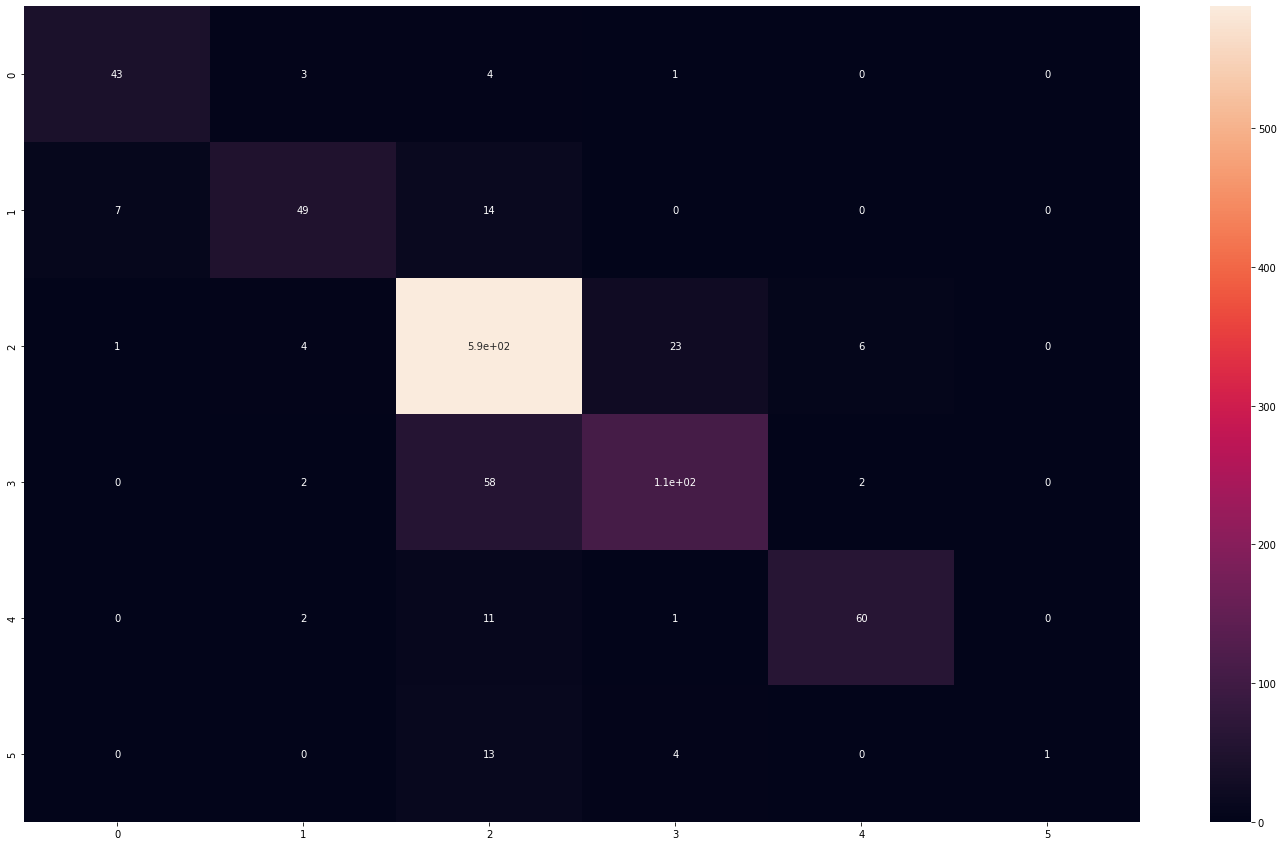


======================================== MultinomialNB ========================================
------------------------------=> Train report <=------------------------------

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       1.00      0.05      0.09       241
                                                 Credit card or prepaid card       0.88      0.03      0.05       273
Credit reporting, credit repair services, or other personal consumer reports       0.64      1.00      0.78      2529
                                                             Debt collection       1.00      0.07      0.13       621
                                                                    Mortgage       1.00      0.07      0.13       263
                                                       Vehicle loan or lease       0.00      0.00      0.00       

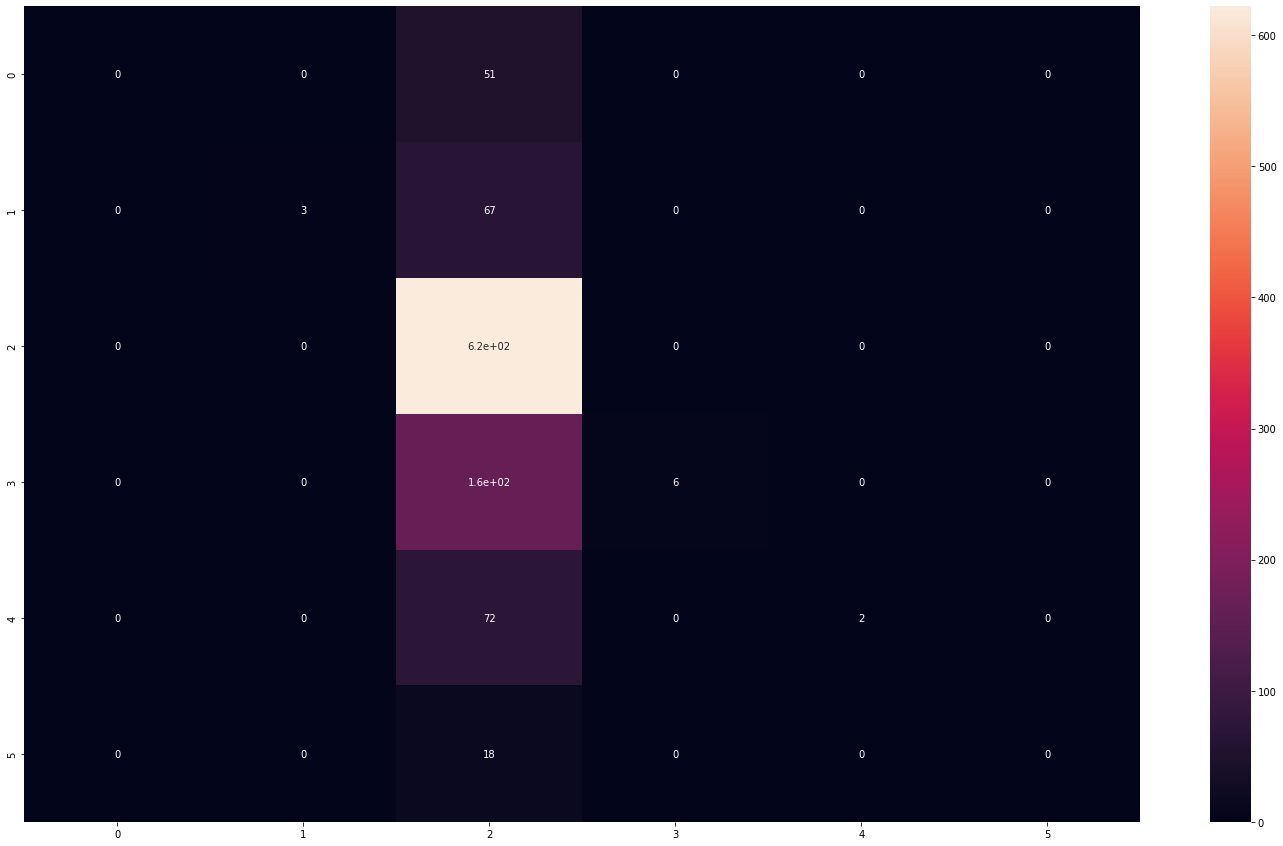


======================================== LinearSVC ========================================
------------------------------=> Train report <=------------------------------

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.99      0.99      0.99       241
                                                 Credit card or prepaid card       0.98      0.96      0.97       273
Credit reporting, credit repair services, or other personal consumer reports       0.97      0.99      0.98      2529
                                                             Debt collection       0.96      0.91      0.94       621
                                                                    Mortgage       0.99      0.98      0.99       263
                                                       Vehicle loan or lease       1.00      0.94      0.97        89


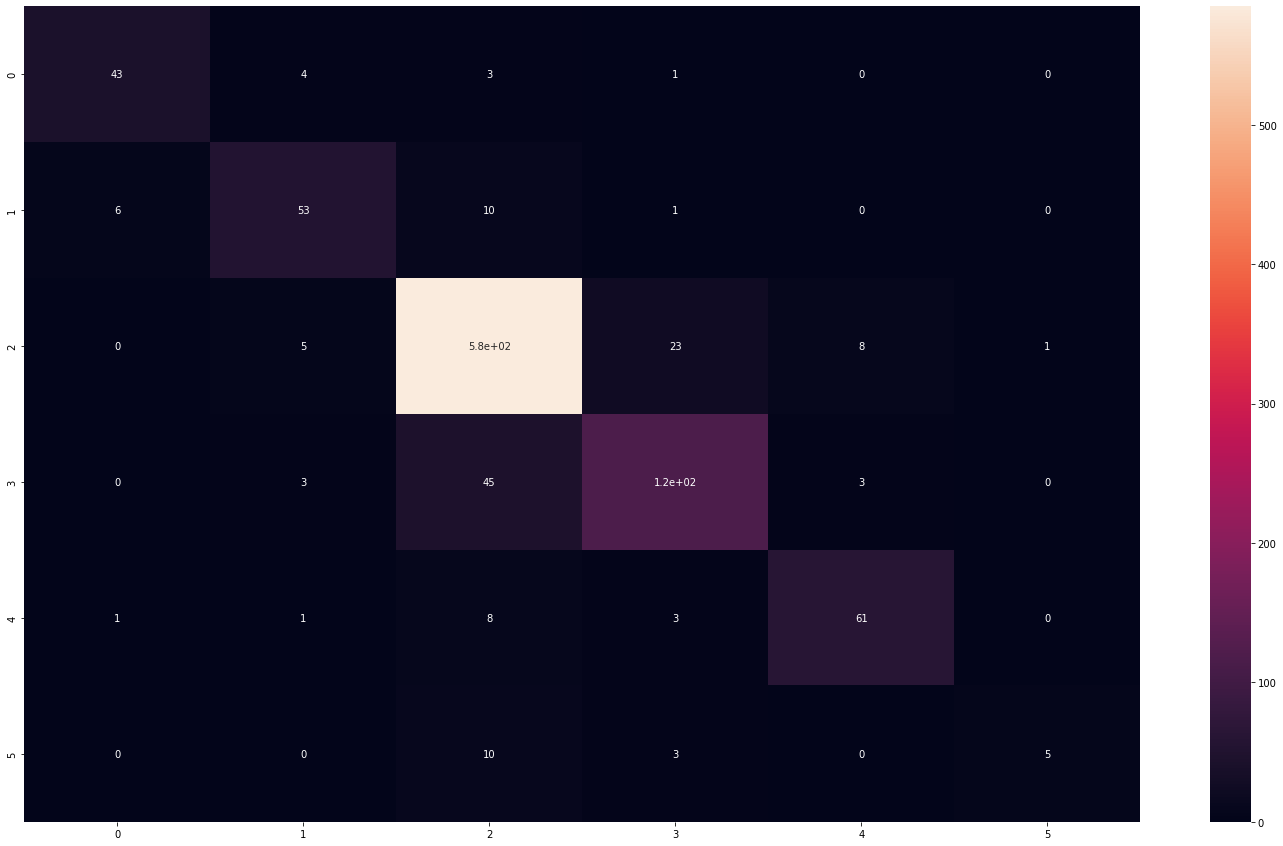


======================================== DecisionTreeClassifier ========================================
------------------------------=> Train report <=------------------------------

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       1.00      1.00      1.00       241
                                                 Credit card or prepaid card       1.00      1.00      1.00       273
Credit reporting, credit repair services, or other personal consumer reports       1.00      1.00      1.00      2529
                                                             Debt collection       1.00      0.99      1.00       621
                                                                    Mortgage       1.00      1.00      1.00       263
                                                       Vehicle loan or lease       1.00      1.00      1.

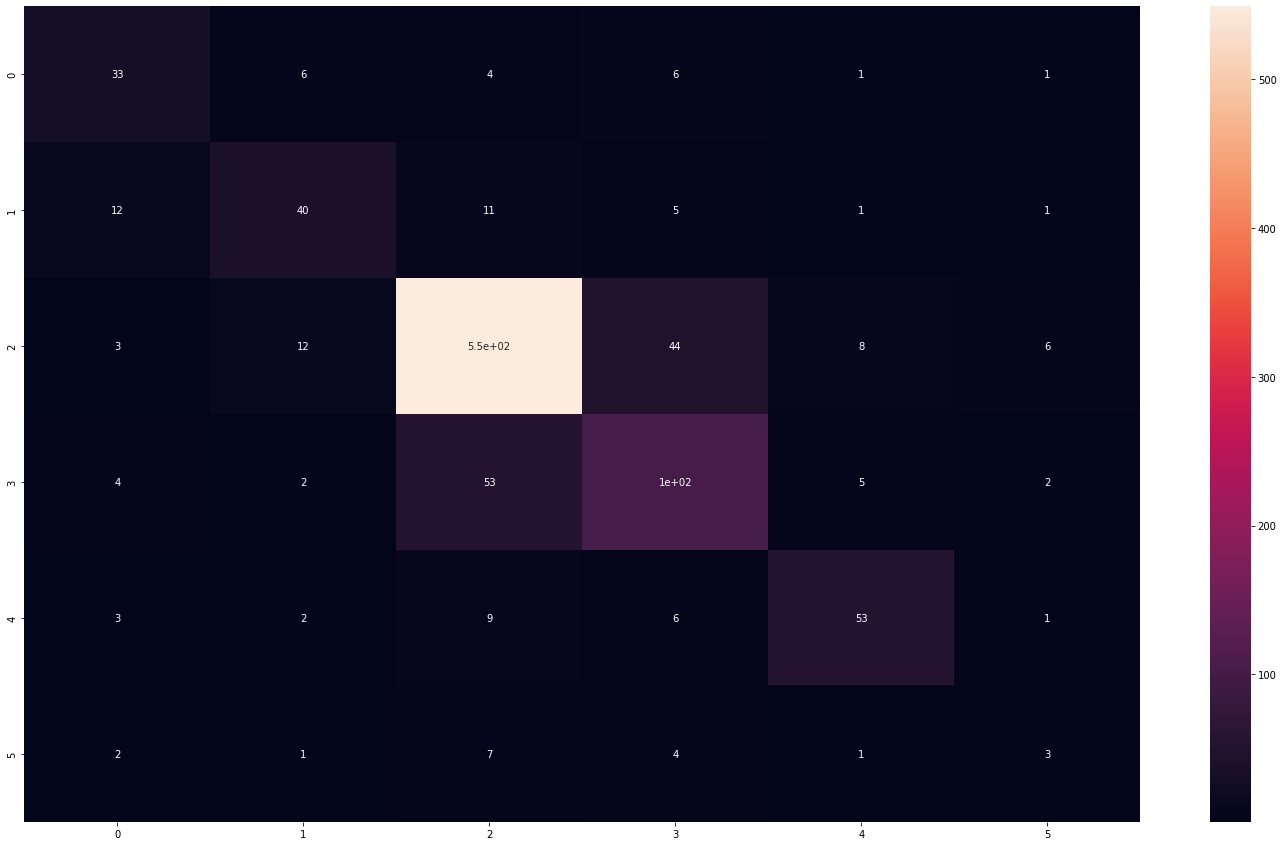


======================================== RandomForestClassifier ========================================
------------------------------=> Train report <=------------------------------

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       1.00      1.00      1.00       241
                                                 Credit card or prepaid card       1.00      1.00      1.00       273
Credit reporting, credit repair services, or other personal consumer reports       1.00      1.00      1.00      2529
                                                             Debt collection       1.00      1.00      1.00       621
                                                                    Mortgage       1.00      1.00      1.00       263
                                                       Vehicle loan or lease       1.00      1.00      1.

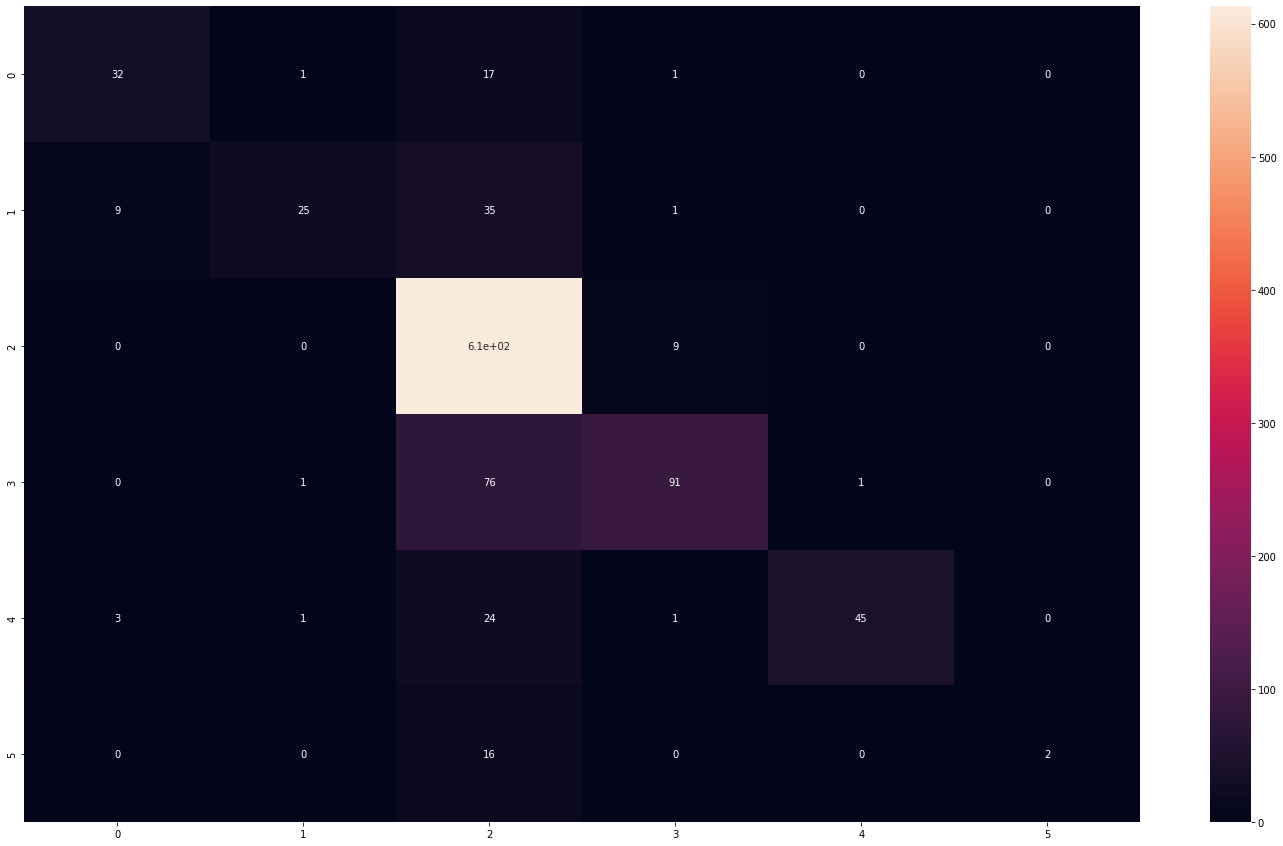

In [ ]:
## models evaluation 
models_evaluation(models= models, model_names = model_names, X_train = X_train_en, y_train = y_train_en, X_test = X_test_en,
                  y_test = y_test_en, y_label_names= y_label_en.classes_)

In [ ]:
## choosing the best model
product_model = LinearSVC()
product_model.fit(X_train_en , y_train_en)

LinearSVC()

## Sub-product classifier

In [ ]:
X_train_en , X_test_en , y_train_en , y_test_en, y_label_en  = transform_and_split(df_sub_product, 'sub_product')

In [ ]:
X_test_en.shape

(911, 5766)

======================================== LogisticRegression ========================================
------------------------------=> Train report <=------------------------------

                                            precision    recall  f1-score   support

                          Checking account       0.93      0.90      0.92       193
                Conventional home mortgage       0.97      0.83      0.89       169
                          Credit card debt       0.93      0.51      0.66       168
                          Credit reporting       0.87      0.99      0.93      2503
General-purpose credit card or charge card       0.90      0.78      0.83       209
                             I do not know       0.94      0.32      0.48       107
                              Medical debt       0.87      0.44      0.58       108
                                Other debt       0.81      0.45      0.58       183

                                  accuracy                   

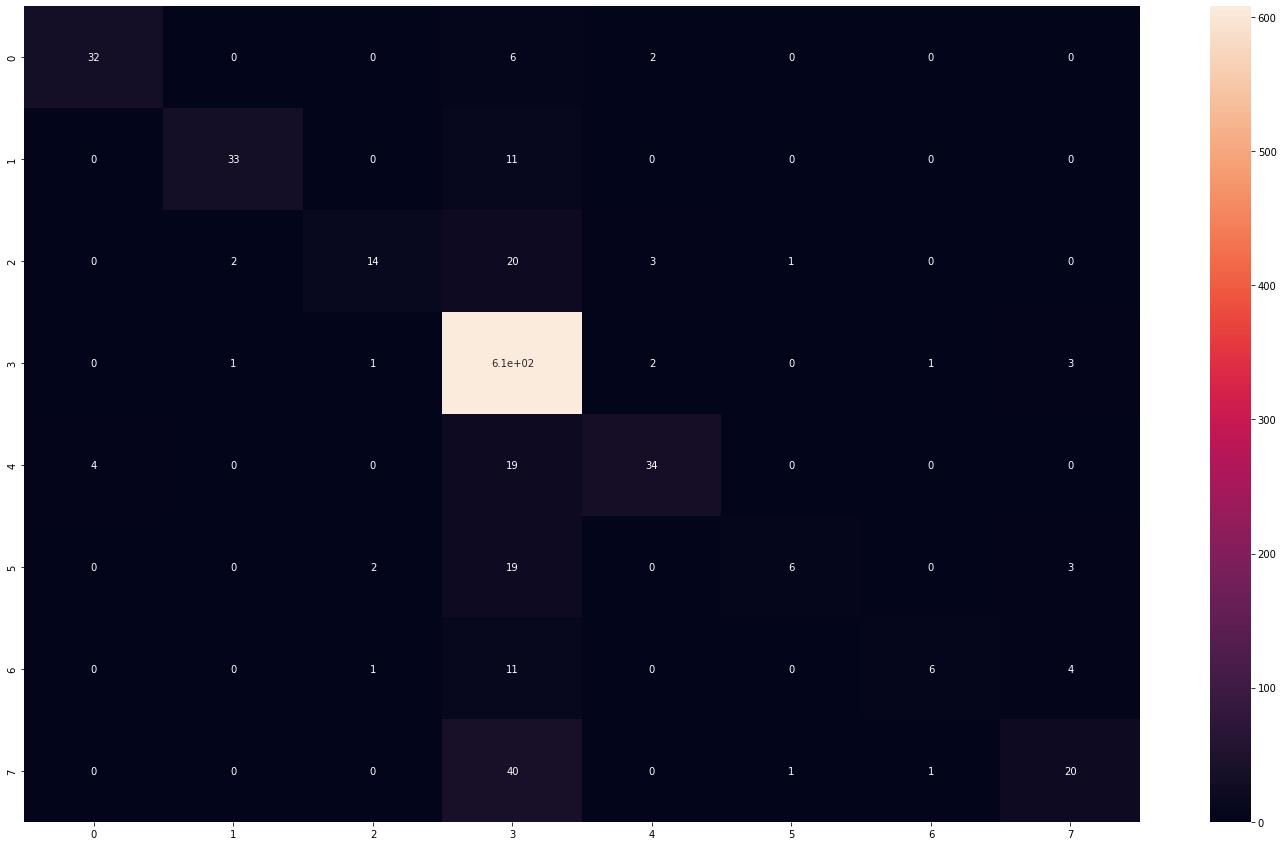


======================================== MultinomialNB ========================================
------------------------------=> Train report <=------------------------------

                                            precision    recall  f1-score   support

                          Checking account       1.00      0.02      0.03       193
                Conventional home mortgage       0.00      0.00      0.00       169
                          Credit card debt       0.00      0.00      0.00       168
                          Credit reporting       0.69      1.00      0.82      2503
General-purpose credit card or charge card       1.00      0.01      0.02       209
                             I do not know       0.00      0.00      0.00       107
                              Medical debt       0.00      0.00      0.00       108
                                Other debt       1.00      0.01      0.01       183

                                  accuracy                       

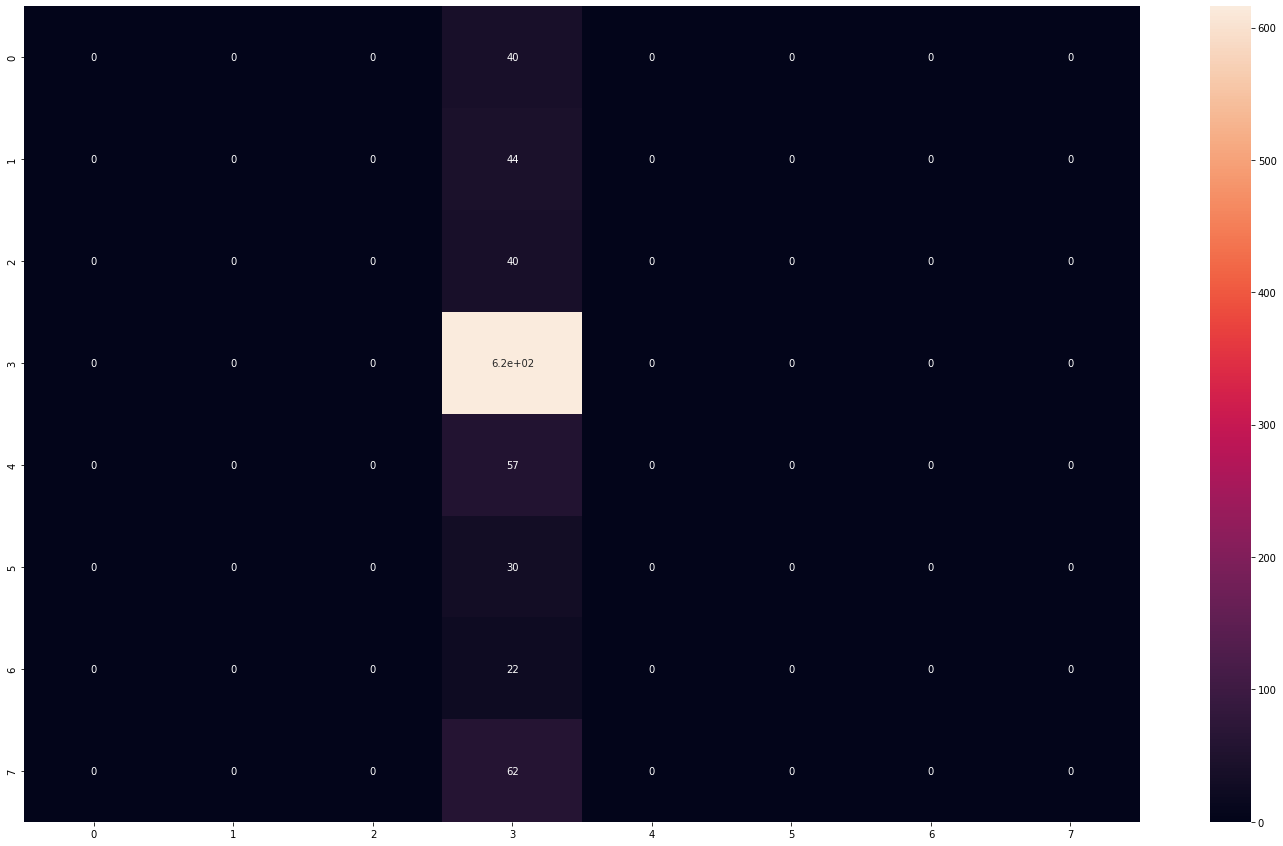


======================================== LinearSVC ========================================
------------------------------=> Train report <=------------------------------

                                            precision    recall  f1-score   support

                          Checking account       1.00      0.99      1.00       193
                Conventional home mortgage       1.00      0.97      0.98       169
                          Credit card debt       0.94      0.95      0.94       168
                          Credit reporting       0.97      1.00      0.99      2503
General-purpose credit card or charge card       1.00      0.98      0.99       209
                             I do not know       0.99      0.79      0.88       107
                              Medical debt       0.98      0.90      0.94       108
                                Other debt       0.99      0.89      0.93       183

                                  accuracy                           

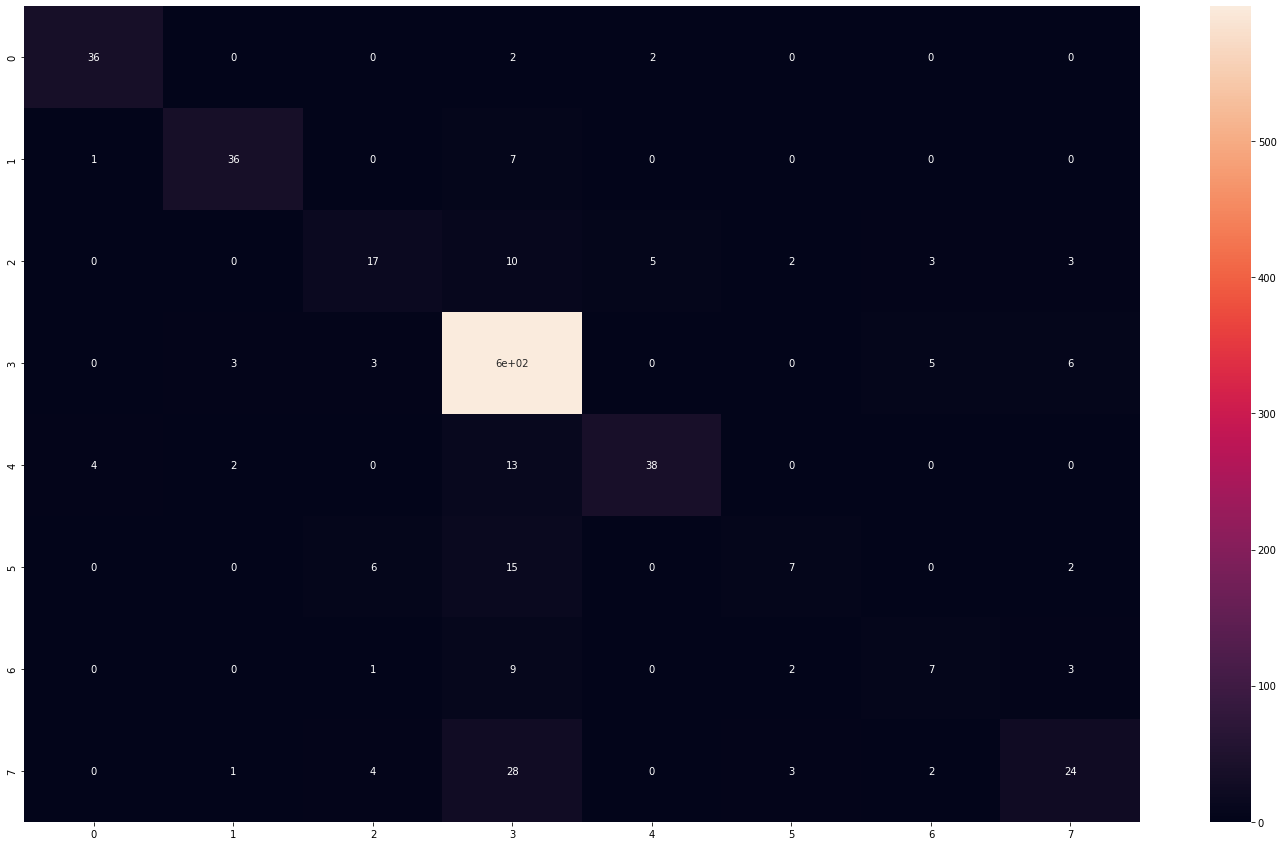


======================================== DecisionTreeClassifier ========================================
------------------------------=> Train report <=------------------------------

                                            precision    recall  f1-score   support

                          Checking account       1.00      1.00      1.00       193
                Conventional home mortgage       1.00      1.00      1.00       169
                          Credit card debt       0.99      1.00      1.00       168
                          Credit reporting       1.00      1.00      1.00      2503
General-purpose credit card or charge card       1.00      1.00      1.00       209
                             I do not know       1.00      0.99      1.00       107
                              Medical debt       1.00      0.99      1.00       108
                                Other debt       1.00      0.99      1.00       183

                                  accuracy              

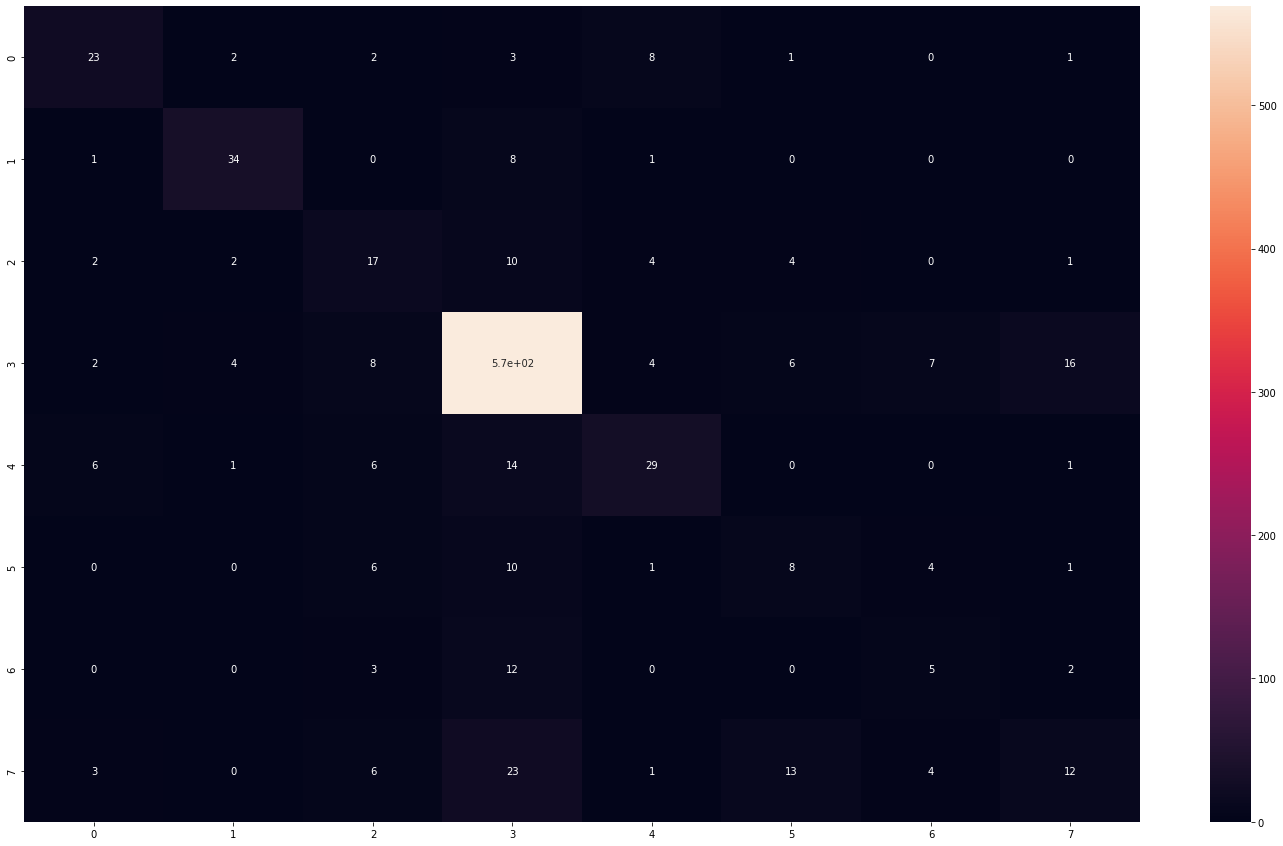


======================================== RandomForestClassifier ========================================
------------------------------=> Train report <=------------------------------

                                            precision    recall  f1-score   support

                          Checking account       1.00      1.00      1.00       193
                Conventional home mortgage       1.00      1.00      1.00       169
                          Credit card debt       0.99      1.00      1.00       168
                          Credit reporting       1.00      1.00      1.00      2503
General-purpose credit card or charge card       1.00      1.00      1.00       209
                             I do not know       1.00      0.99      1.00       107
                              Medical debt       1.00      0.99      1.00       108
                                Other debt       1.00      0.99      1.00       183

                                  accuracy              

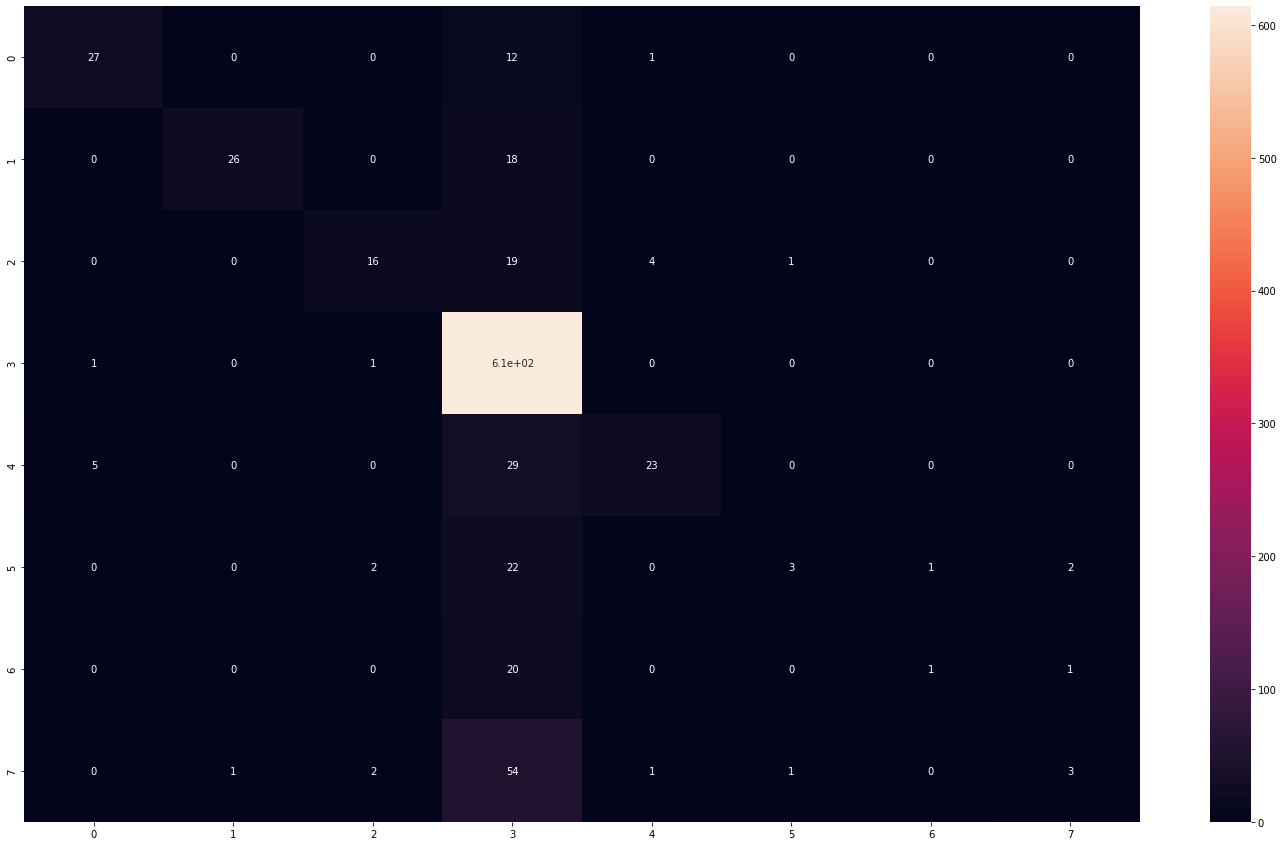

In [ ]:
## models evaluation 
models_evaluation(models= models, model_names = model_names, X_train = X_train_en, y_train = y_train_en, X_test = X_test_en,
                  y_test = y_test_en, y_label_names= y_label_en.classes_)

In [ ]:
## choosing the best model
sub_product_model = LinearSVC()
sub_product_model.fit(X_train_en , y_train_en)

LinearSVC()

## 	Issue	 classifier

In [ ]:
X_train_en , X_test_en , y_train_en , y_test_en, y_label_en  = transform_and_split(df_issue, 'issue')

In [ ]:
X_test_en.shape

(799, 5179)

======================================== LogisticRegression ========================================
------------------------------=> Train report <=------------------------------

                                                                                  precision    recall  f1-score   support

                                               Attempts to collect debt not owed       0.78      0.69      0.73       345
                                                     Improper use of your report       0.83      0.69      0.75       305
                                            Incorrect information on your report       0.76      0.91      0.83      1329
                                                             Managing an account       0.95      0.95      0.95       132
Problem with a credit reporting company's investigation into an existing problem       0.83      0.73      0.78       836
                                                  Trouble during payment process      

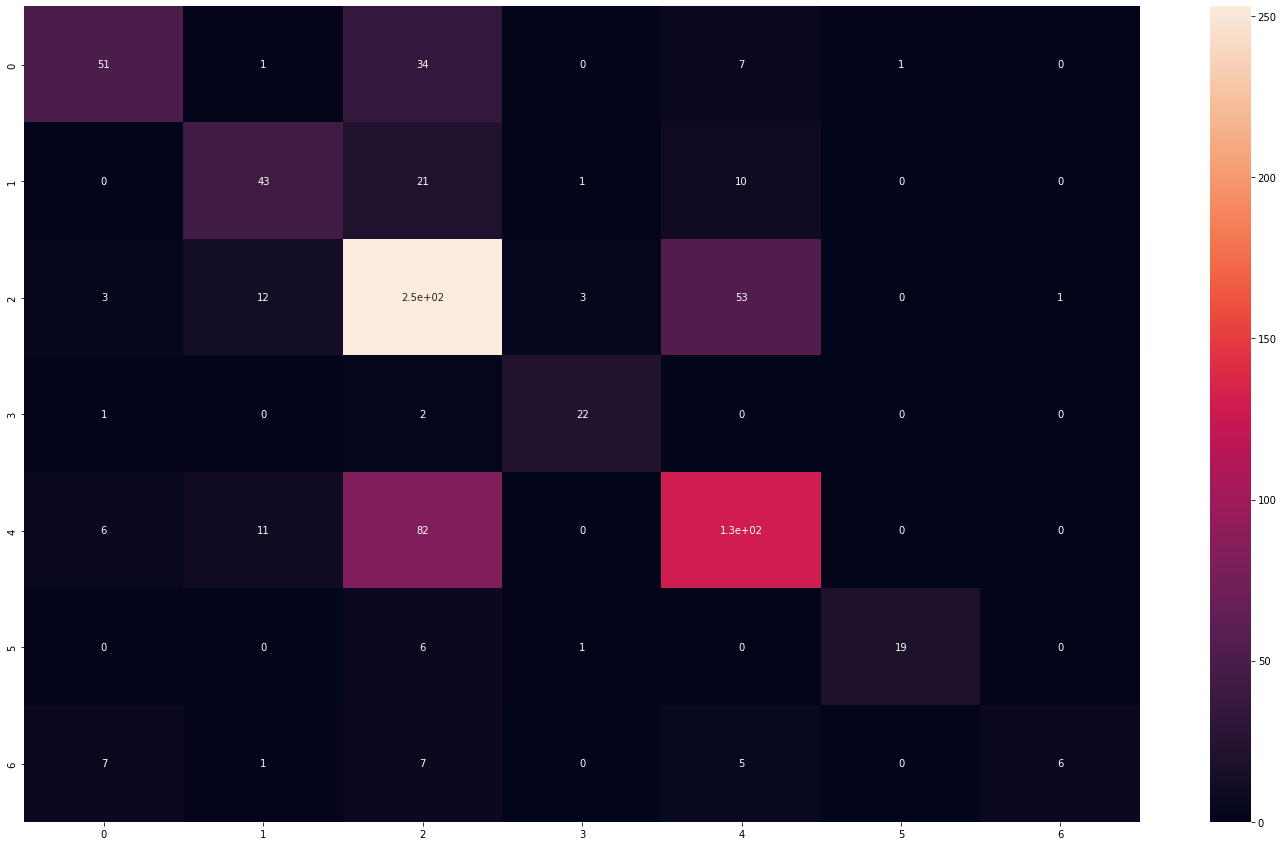


======================================== MultinomialNB ========================================
------------------------------=> Train report <=------------------------------

                                                                                  precision    recall  f1-score   support

                                               Attempts to collect debt not owed       0.93      0.08      0.15       345
                                                     Improper use of your report       0.00      0.00      0.00       305
                                            Incorrect information on your report       0.48      0.98      0.64      1329
                                                             Managing an account       1.00      0.01      0.02       132
Problem with a credit reporting company's investigation into an existing problem       0.82      0.43      0.56       836
                                                  Trouble during payment process       0.0

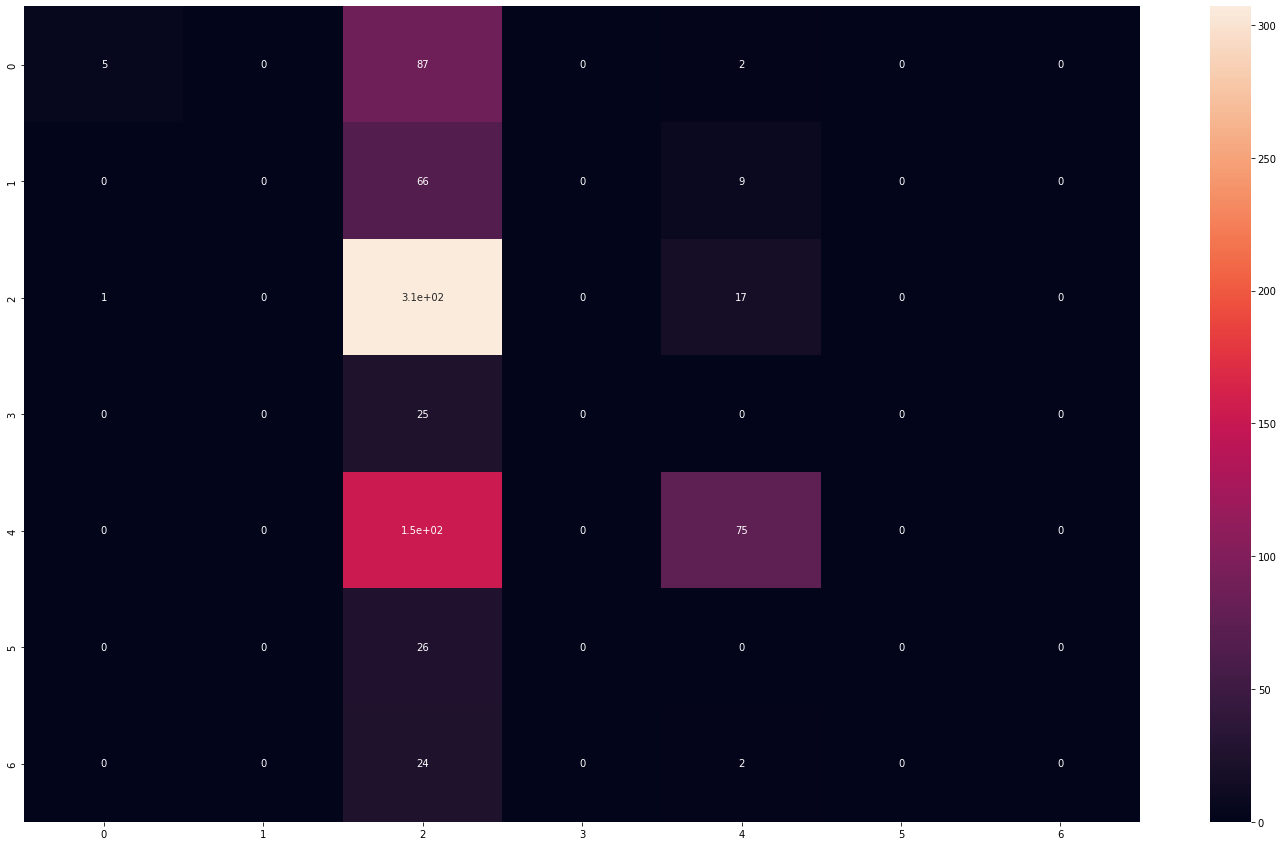


======================================== LinearSVC ========================================
------------------------------=> Train report <=------------------------------

                                                                                  precision    recall  f1-score   support

                                               Attempts to collect debt not owed       0.97      0.93      0.95       345
                                                     Improper use of your report       0.94      0.90      0.92       305
                                            Incorrect information on your report       0.93      0.96      0.94      1329
                                                             Managing an account       0.99      1.00      1.00       132
Problem with a credit reporting company's investigation into an existing problem       0.93      0.92      0.92       836
                                                  Trouble during payment process       0.99   

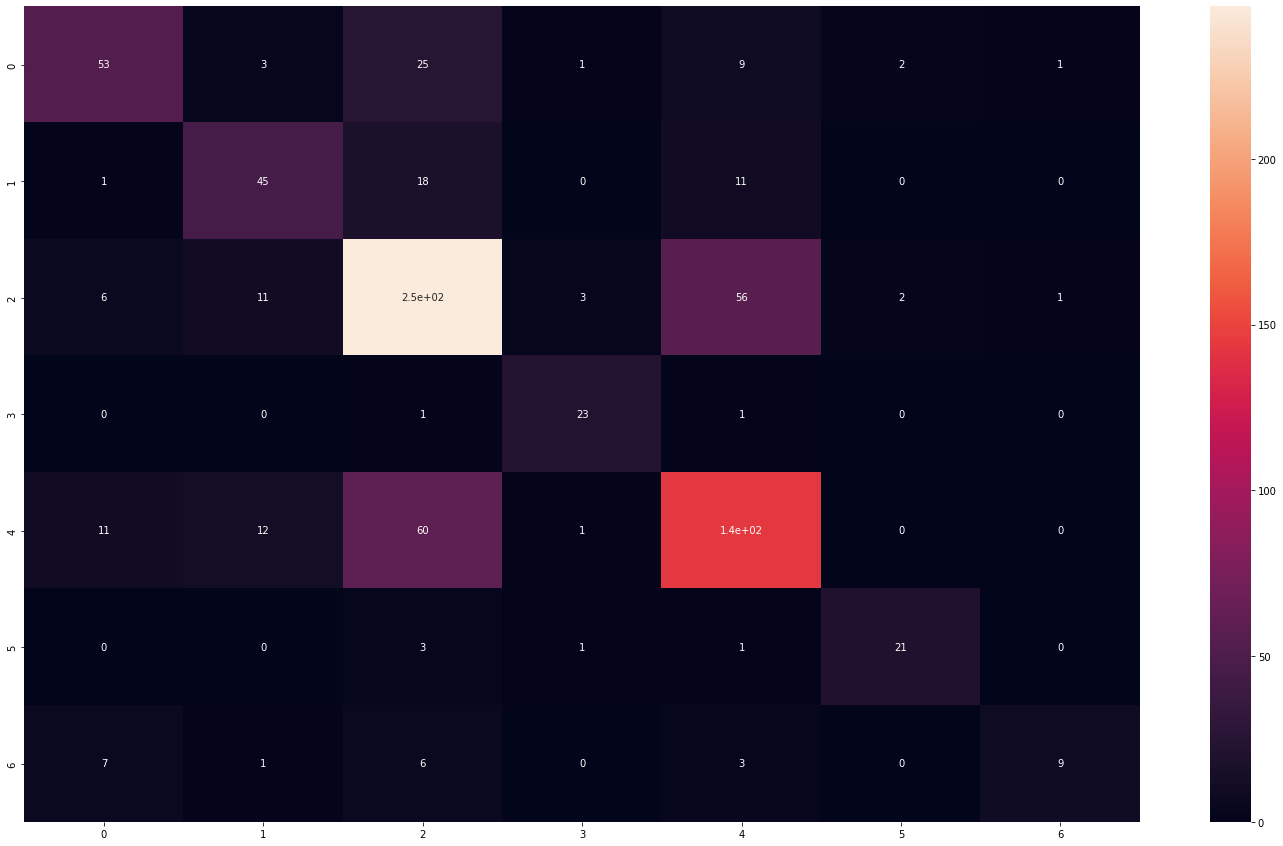


======================================== DecisionTreeClassifier ========================================
------------------------------=> Train report <=------------------------------

                                                                                  precision    recall  f1-score   support

                                               Attempts to collect debt not owed       0.99      1.00      1.00       345
                                                     Improper use of your report       1.00      1.00      1.00       305
                                            Incorrect information on your report       1.00      1.00      1.00      1329
                                                             Managing an account       1.00      1.00      1.00       132
Problem with a credit reporting company's investigation into an existing problem       1.00      0.99      1.00       836
                                                  Trouble during payment process 

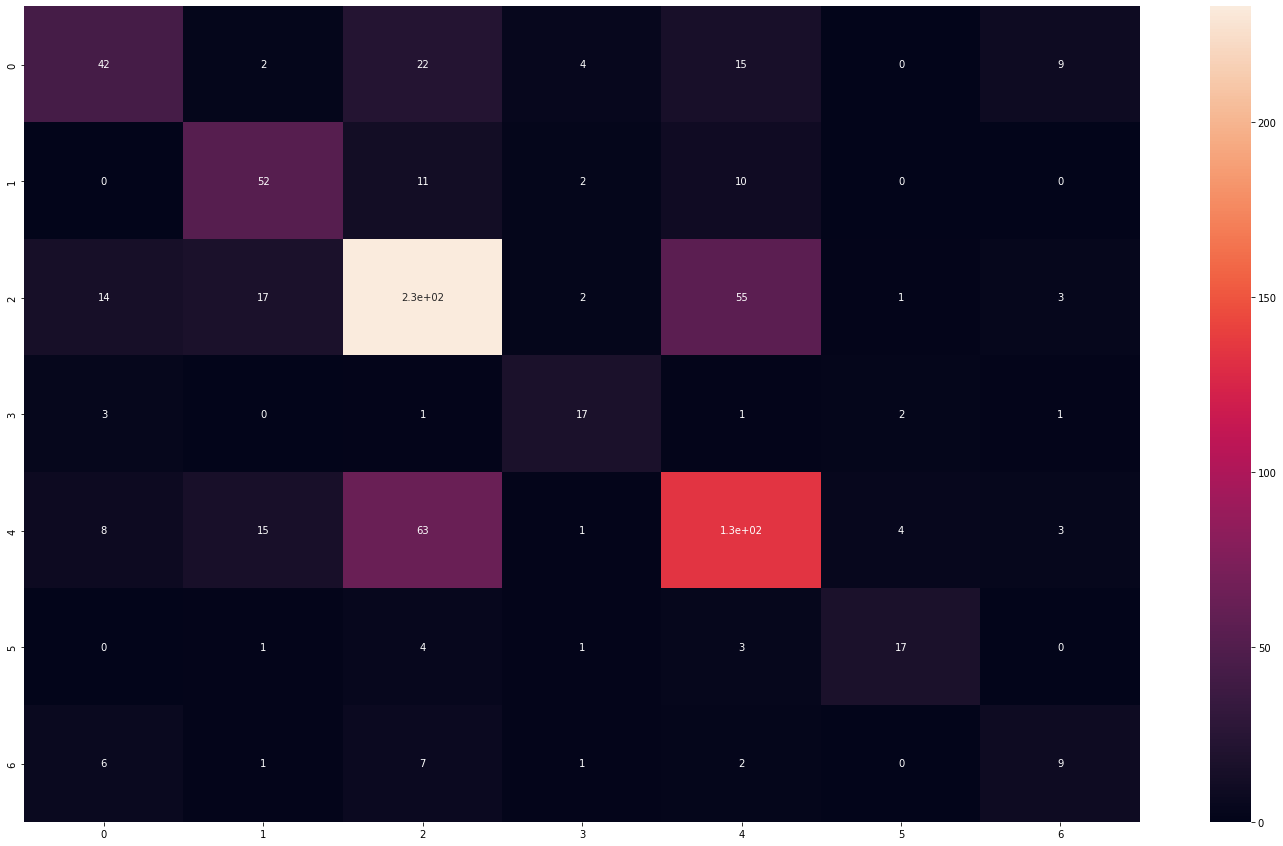


======================================== RandomForestClassifier ========================================
------------------------------=> Train report <=------------------------------

                                                                                  precision    recall  f1-score   support

                                               Attempts to collect debt not owed       1.00      0.99      1.00       345
                                                     Improper use of your report       1.00      1.00      1.00       305
                                            Incorrect information on your report       1.00      1.00      1.00      1329
                                                             Managing an account       1.00      1.00      1.00       132
Problem with a credit reporting company's investigation into an existing problem       0.99      1.00      1.00       836
                                                  Trouble during payment process 

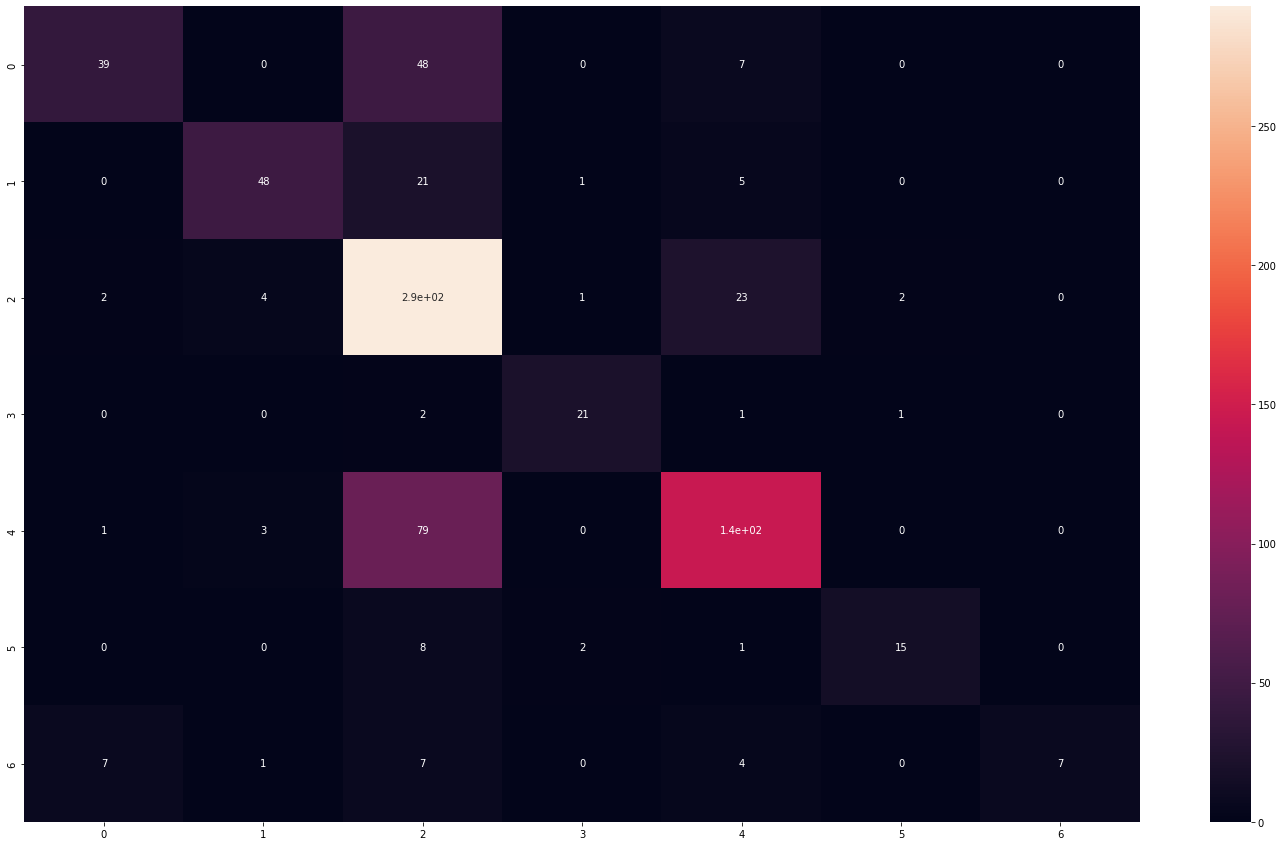

In [ ]:
## models evaluation 
models_evaluation(models= models, model_names = model_names, X_train = X_train_en, y_train = y_train_en, X_test = X_test_en,
                  y_test = y_test_en, y_label_names= y_label_en.classes_)

In [ ]:
## choosing the best model
issue_model = LinearSVC()
issue_model.fit(X_train_en , y_train_en)

LinearSVC()

## Sub-issue classifier

In [ ]:
X_train_en , X_test_en , y_train_en , y_test_en, y_label_en  = transform_and_split(df_sub_issue, 'sub_issue')

In [ ]:
X_test_en.shape

(715, 5048)

======================================== LogisticRegression ========================================
------------------------------=> Train report <=------------------------------

                                                          precision    recall  f1-score   support

                           Account information incorrect       0.84      0.66      0.74       234
                                Account status incorrect       0.78      0.72      0.75       245
Credit inquiries on your report that you don't recognize       0.76      0.70      0.73       170
                                       Debt is not yours       0.73      0.71      0.72       174
                       Debt was result of identity theft       0.87      0.52      0.65       119
                     Information belongs to someone else       0.73      0.89      0.80       653
                    Investigation took more than 30 days       0.84      0.61      0.70       153
                                  

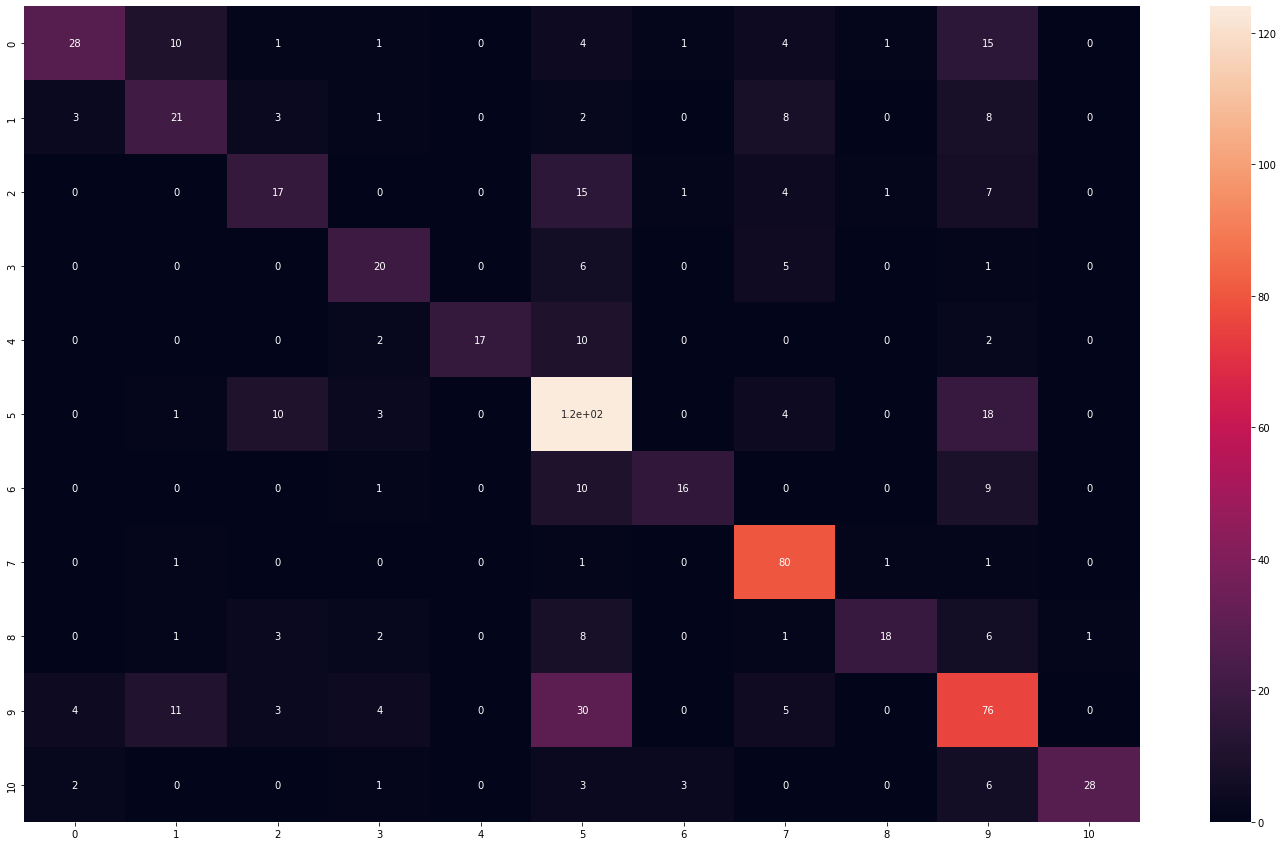


======================================== MultinomialNB ========================================
------------------------------=> Train report <=------------------------------

                                                          precision    recall  f1-score   support

                           Account information incorrect       0.97      0.14      0.24       234
                                Account status incorrect       0.91      0.13      0.23       245
Credit inquiries on your report that you don't recognize       0.00      0.00      0.00       170
                                       Debt is not yours       1.00      0.01      0.02       174
                       Debt was result of identity theft       1.00      0.13      0.24       119
                     Information belongs to someone else       0.36      0.98      0.53       653
                    Investigation took more than 30 days       0.00      0.00      0.00       153
                                      

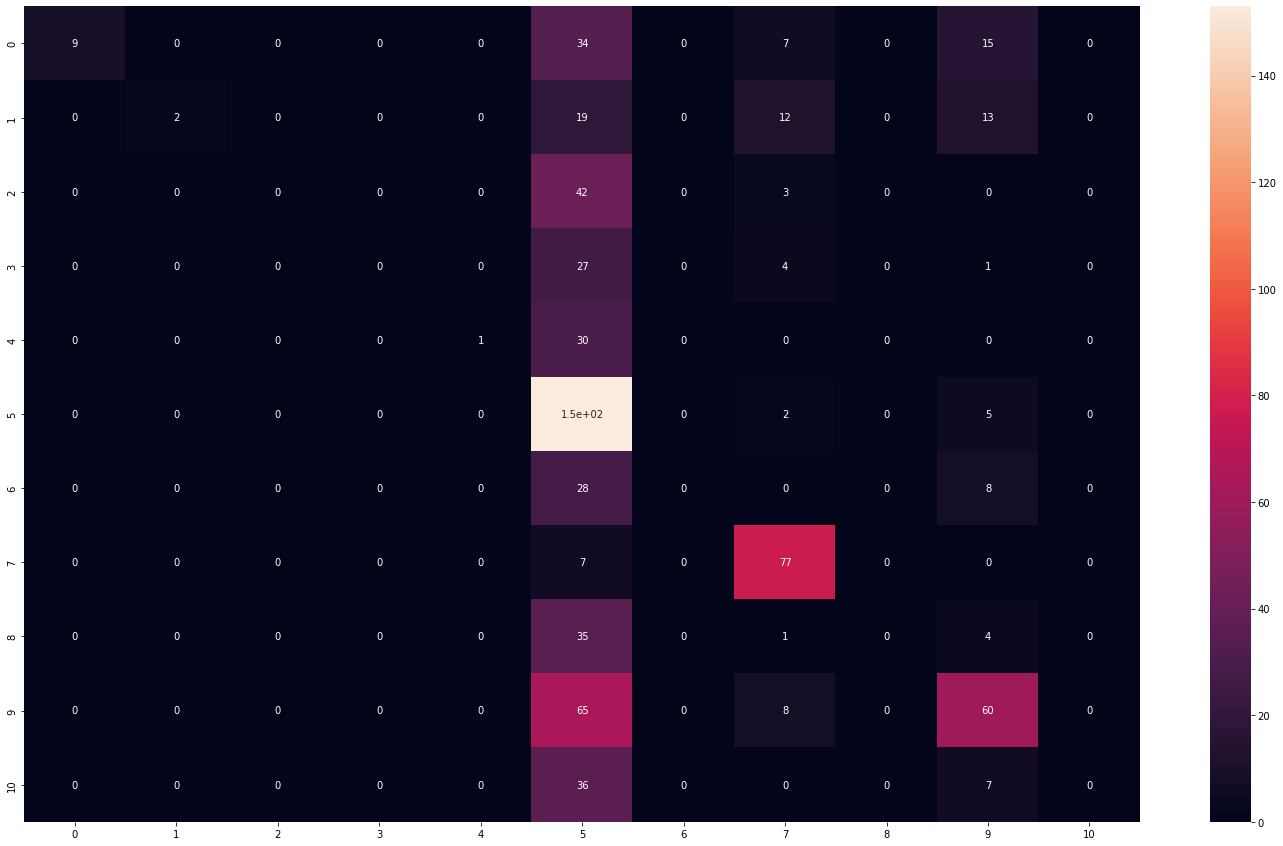


======================================== LinearSVC ========================================
------------------------------=> Train report <=------------------------------

                                                          precision    recall  f1-score   support

                           Account information incorrect       0.95      0.95      0.95       234
                                Account status incorrect       0.94      0.97      0.96       245
Credit inquiries on your report that you don't recognize       0.93      0.96      0.95       170
                                       Debt is not yours       0.98      0.97      0.97       174
                       Debt was result of identity theft       0.96      0.94      0.95       119
                     Information belongs to someone else       0.94      0.96      0.95       653
                    Investigation took more than 30 days       0.94      0.92      0.93       153
                                          

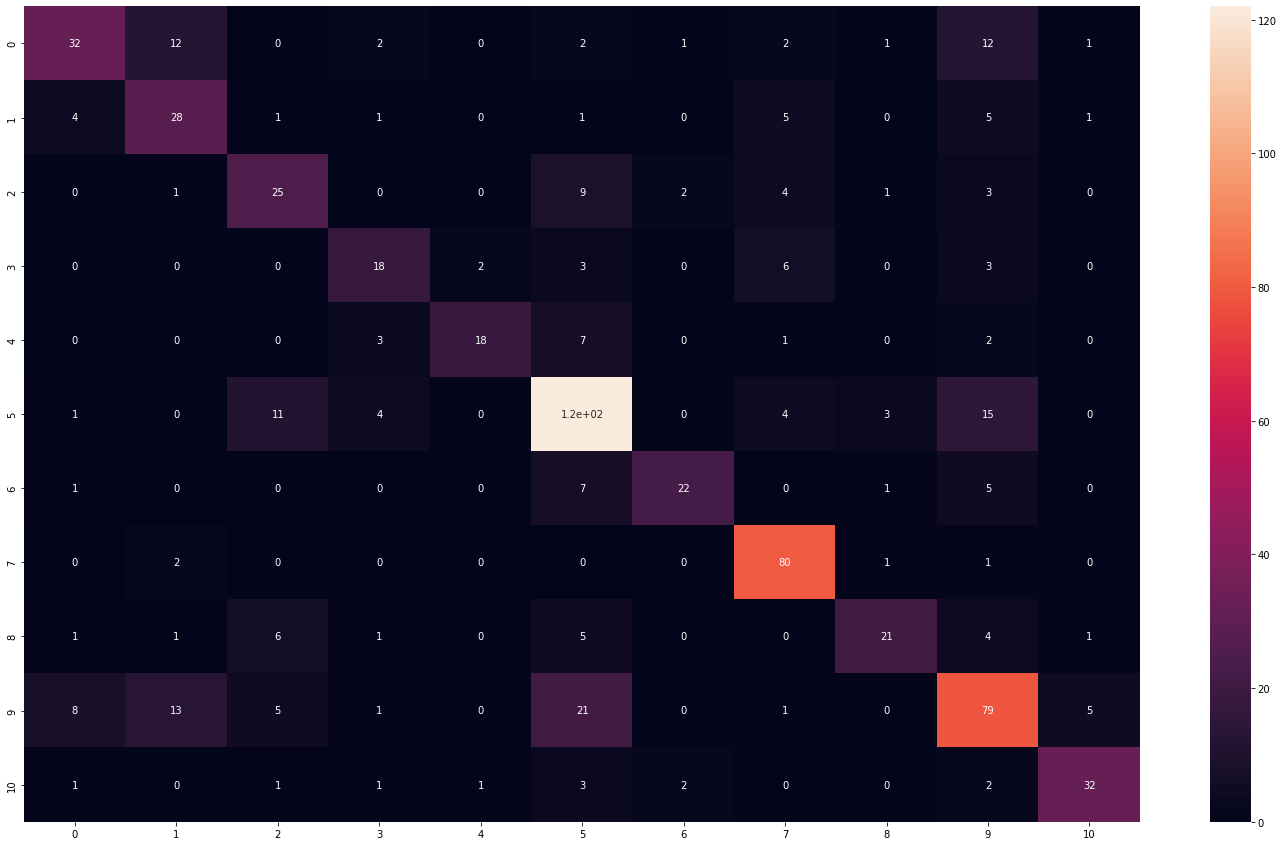


======================================== DecisionTreeClassifier ========================================
------------------------------=> Train report <=------------------------------

                                                          precision    recall  f1-score   support

                           Account information incorrect       0.98      0.99      0.99       234
                                Account status incorrect       1.00      1.00      1.00       245
Credit inquiries on your report that you don't recognize       0.99      0.99      0.99       170
                                       Debt is not yours       0.99      0.99      0.99       174
                       Debt was result of identity theft       0.98      0.99      0.99       119
                     Information belongs to someone else       1.00      1.00      1.00       653
                    Investigation took more than 30 days       0.99      0.99      0.99       153
                             

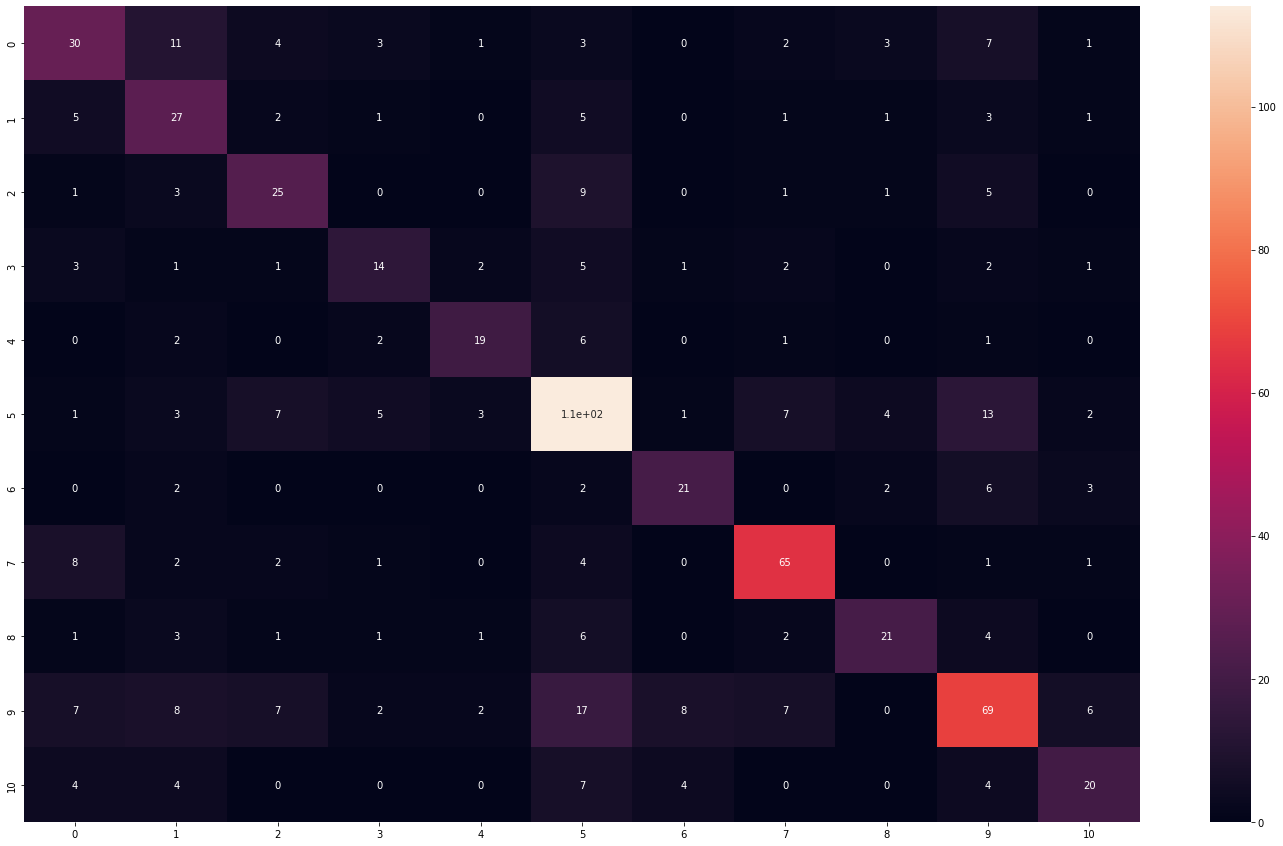


======================================== RandomForestClassifier ========================================
------------------------------=> Train report <=------------------------------

                                                          precision    recall  f1-score   support

                           Account information incorrect       0.99      0.98      0.99       234
                                Account status incorrect       1.00      1.00      1.00       245
Credit inquiries on your report that you don't recognize       1.00      0.99      0.99       170
                                       Debt is not yours       0.99      0.99      0.99       174
                       Debt was result of identity theft       0.98      1.00      0.99       119
                     Information belongs to someone else       1.00      1.00      1.00       653
                    Investigation took more than 30 days       0.99      0.99      0.99       153
                             

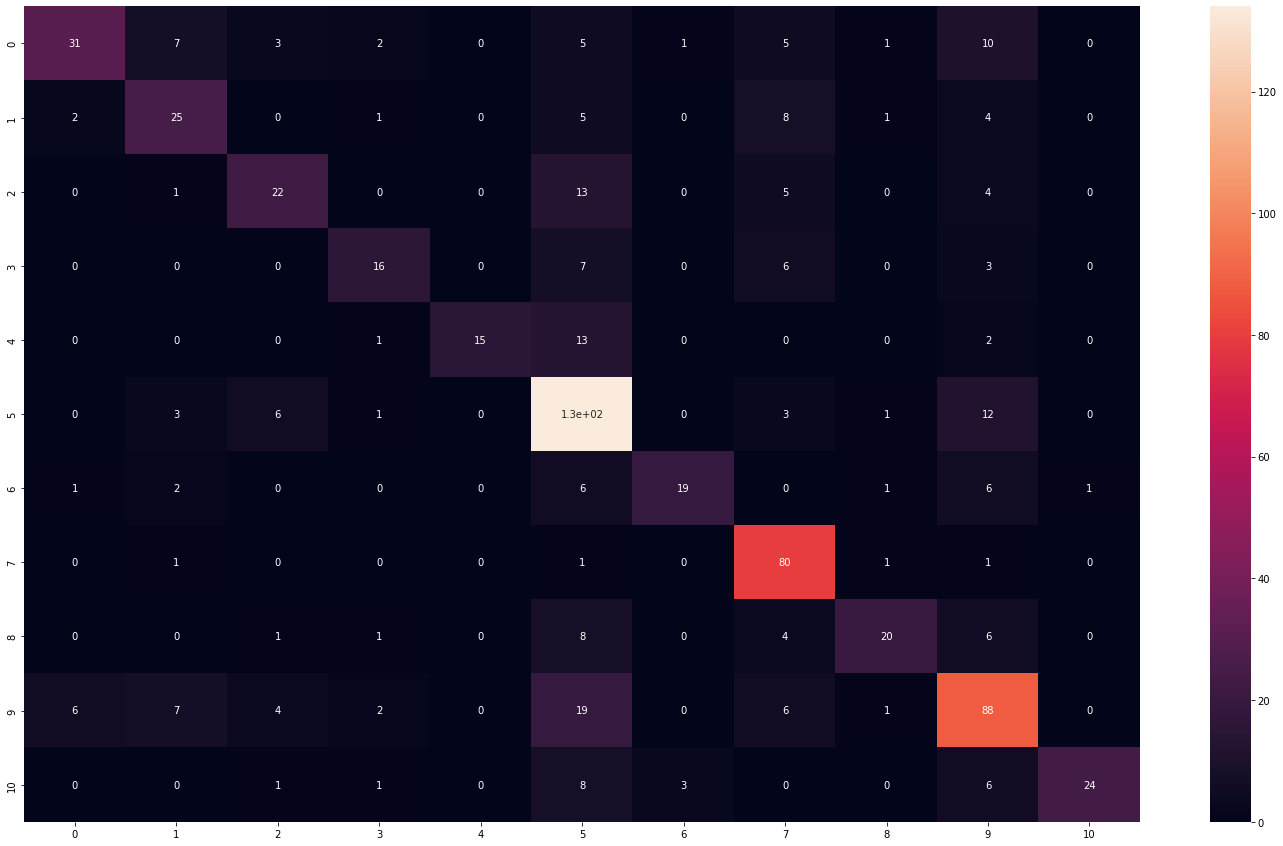

In [ ]:
## models evaluation 
models_evaluation(models= models, model_names = model_names, X_train = X_train_en, y_train = y_train_en, X_test = X_test_en,
                  y_test = y_test_en, y_label_names= y_label_en.classes_)

In [ ]:
## choosing the best model
sub_issue_model = LinearSVC()
sub_issue_model.fit(X_train_en , y_train_en)

LinearSVC()

## saving models

In [ ]:
##save model of product classifier
output = open('product_model.pkl', 'wb')
pickle.dump(product_model, output)
output.close()

##save model of sub product classifier
output = open('sub_product_model.pkl', 'wb')
pickle.dump(sub_product_model, output)
output.close()

##save model of issue classifier
output = open('issue_model.pkl', 'wb')
pickle.dump(issue_model, output)
output.close()

##save model of sub issue classifier
output = open('sub_issue_model.pkl', 'wb')
pickle.dump(sub_issue_model, output)
output.close()